# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [186]:
from utils import *

In [187]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef as phi_coef
import json
from torch import save, load

In [188]:
import phik

#from phik import resources
#from phik.binning import bin_data
from phik.report import plot_correlation_matrix

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [189]:
seed = 2609612152#randint(0, 4294967295) #60412887
print(seed)

2609612152


In [190]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure', 
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv('data/heart/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

print(f'Nº de instâncias: {len(df)}')
df.head()

Nº de instâncias: 270


age  sex  chest_pain  blood_pressure  cholestoral  blood_sugar  \
0  70.0  1.0         4.0           130.0        322.0          0.0   
1  67.0  0.0         3.0           115.0        564.0          0.0   
2  57.0  1.0         2.0           124.0        261.0          0.0   
3  64.0  1.0         4.0           128.0        263.0          0.0   
4  74.0  0.0         2.0           120.0        269.0          0.0   

   eletro_results  max_heart_rate  exer_angina  oldpeak  slope_peak  \
0             2.0           109.0          0.0      2.4         2.0   
1             2.0           160.0          0.0      1.6         2.0   
2             0.0           141.0          0.0      0.3         1.0   
3             0.0           105.0          1.0      0.2         2.0   
4             2.0           121.0          1.0      0.2         1.0   

   major_vessels  thal  target  
0            3.0   3.0       1  
1            0.0   7.0       0  
2            0.0   7.0       1  
3            1.0   7.0       0  
4            1.0   3.0       0

<Axes: >

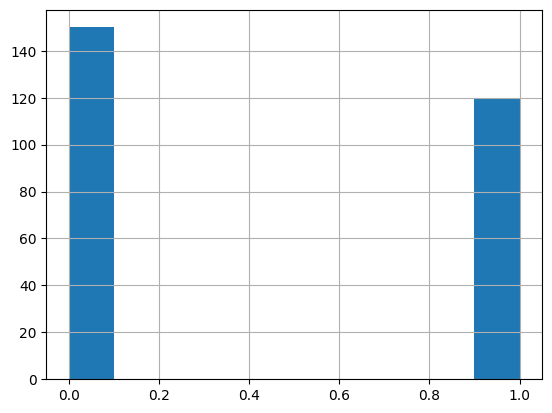

In [191]:
df['target'].hist()

<Axes: >

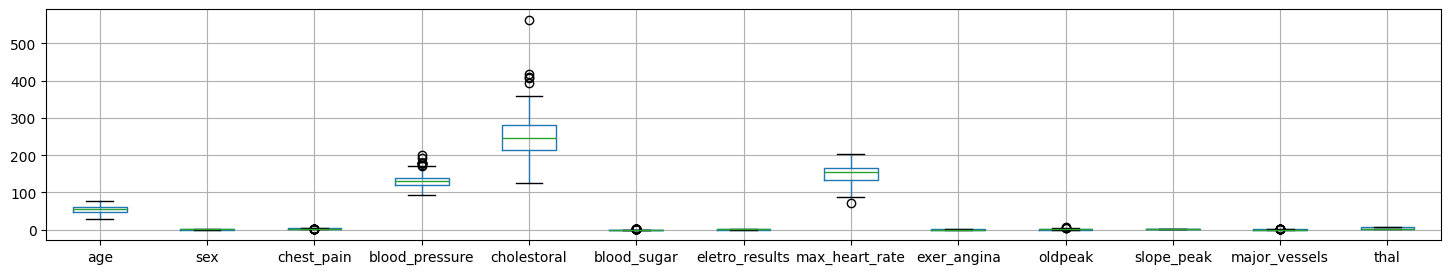

In [192]:
plt.figure(figsize=(18,3))
df[cols].boxplot()

<Axes: >

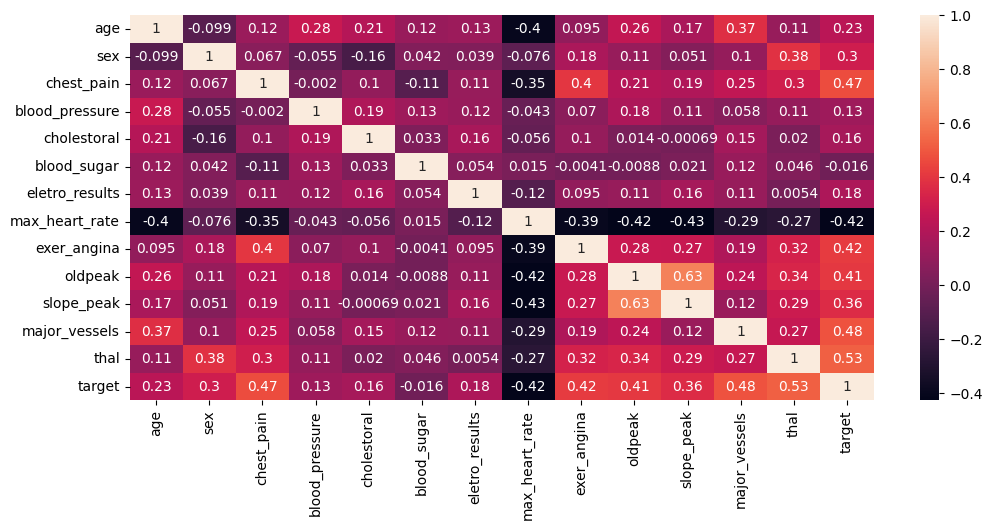

In [193]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr('spearman'), annot=True)

In [194]:
df.corr('spearman').dtypes

age               float64
sex               float64
chest_pain        float64
blood_pressure    float64
cholestoral       float64
blood_sugar       float64
eletro_results    float64
max_heart_rate    float64
exer_angina       float64
oldpeak           float64
slope_peak        float64
major_vessels     float64
thal              float64
target            float64
dtype: object

correlação regular entre:
- target e [chest_pain, max_heart_rate, exer_angina, oldpeak, major_vessels, thal]
- chest_pain e exer_angina
- max_heart_rate e [age, oldpeak, slope_peak]
- oldpeak e slope_peak

In [195]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [196]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

# se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

In [197]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [198]:
performs = {}
models_error = pd.DataFrame()
models = []

In [199]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}
    return pdict

### Decision Tree

In [200]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [201]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.8404
Recall:           0.9362
Precision:        0.7857
F1:               0.8544
AUROC:            0.9108
AUPR:             0.8889
1-maxProb média:  0.1596
1-maxProb dp:     0.1609

[Testing]

Accuracy:         0.7474
Recall:           0.9459
Precision:        0.6140
F1:               0.7447
AUROC:            0.8318
AUPR:             0.6766
1-maxProb média:  0.1787
1-maxProb dp:     0.1596


In [202]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0  0.357143
1  0.965517
2  0.357143
3  0.461538
4  0.078947

In [203]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [204]:
#sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'log_loss', 'penalty': 'l1'}


In [205]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.8936
Recall:           0.8511
Precision:        0.9302
F1:               0.8889
AUROC:            0.9670
AUPR:             0.9704
1-maxProb média:  0.1241
1-maxProb dp:     0.1313

[Testing]

Accuracy:         0.8000
Recall:           0.8919
Precision:        0.6875
F1:               0.7765
AUROC:            0.8700
AUPR:             0.7426
1-maxProb média:  0.1531
1-maxProb dp:     0.1398


### Logistic Regression

In [206]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [207]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.8723
Recall:           0.8298
Precision:        0.9070
F1:               0.8667
AUROC:            0.9593
AUPR:             0.9632
1-maxProb média:  0.1991
1-maxProb dp:     0.1231

[Testing]

Accuracy:         0.8000
Recall:           0.7838
Precision:        0.7250
F1:               0.7532
AUROC:            0.8914
AUPR:             0.8023
1-maxProb média:  0.2386
1-maxProb dp:     0.1275


### K-Nearest Neighbors

(KNN)

In [208]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'uniform'}


In [209]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

[Training]

Accuracy:         0.8617
Recall:           0.7872
Precision:        0.9250
F1:               0.8506
AUROC:            0.9350
AUPR:             0.9311
1-maxProb média:  0.1996
1-maxProb dp:     0.1341

[Testing]

Accuracy:         0.8421
Recall:           0.7838
Precision:        0.8056
F1:               0.7945
AUROC:            0.9091
AUPR:             0.8460
1-maxProb média:  0.2198
1-maxProb dp:     0.1426


### Support Vector Machine - Linear
(SVM)

In [210]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 0.1}


In [211]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.8723
Recall:           0.8511
Precision:        0.8889
F1:               0.8696
AUROC:            0.9588
AUPR:             0.9610
1-maxProb média:  0.1726
1-maxProb dp:     0.1209

[Testing]

Accuracy:         0.7474
Recall:           0.7838
Precision:        0.6444
F1:               0.7073
AUROC:            0.8681
AUPR:             0.7761
1-maxProb média:  0.2227
1-maxProb dp:     0.1389


### Support Vector Machine - Polynomial
(SVM)

In [212]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 1, 'degree': 3, 'gamma': 'scale'}


In [213]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9574
Recall:           0.9362
Precision:        0.9778
F1:               0.9565
AUROC:            0.9923
AUPR:             0.9932
1-maxProb média:  0.1359
1-maxProb dp:     0.1205

[Testing]

Accuracy:         0.7474
Recall:           0.7297
Precision:        0.6585
F1:               0.6923
AUROC:            0.8476
AUPR:             0.6949
1-maxProb média:  0.2237
1-maxProb dp:     0.1472


### Support Vector Machine - RBF
(SVM)

In [214]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [215]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.9362
Recall:           0.9362
Precision:        0.9362
F1:               0.9362
AUROC:            0.9896
AUPR:             0.9901
1-maxProb média:  0.1207
1-maxProb dp:     0.0916

[Testing]

Accuracy:         0.7895
Recall:           0.8108
Precision:        0.6977
F1:               0.7500
AUROC:            0.9035
AUPR:             0.8677
1-maxProb média:  0.2082
1-maxProb dp:     0.1550


### Multi-Layer Perceptron
(MLP)

In [216]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'solver': 'sgd'}


In [217]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.9255
Recall:           0.9149
Precision:        0.9348
F1:               0.9247
AUROC:            0.9846
AUPR:             0.9856
1-maxProb média:  0.1262
1-maxProb dp:     0.1304

[Testing]

Accuracy:         0.8000
Recall:           0.8919
Precision:        0.6875
F1:               0.7765
AUROC:            0.8774
AUPR:             0.7919
1-maxProb média:  0.1676
1-maxProb dp:     0.1431


### Kolmogorov-Arnold Network
(KAN)

In [218]:
kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [219]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open('kan_params/heart.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/heart.pkl')
    save(kanet.state_dict(), 'kan_params/heart.pt')
else:
    with open('kan_params/heart.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load('kan_params/heart.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.52e+00 | : 100%|█| 15/15 [00:03<00:00,  4.36it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.31e+00 | : 100%|█| 15/15 [00:03<00:00,  4.58it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 3.47e+00 | : 100%|█| 15/15 [00:03<00:00,  4.66it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.70e+00 | : 100%|█| 15/15 [00:03<00:00,  4.60it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.89e+00 | : 100%|█| 15/15 [00:03<00:00,  4.59it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.11e+00 | : 100%|█| 15/15 [00:03<00:00,  4.72it
| train_loss: 8.34e-01 | test_loss: 8.34e-01 | reg: 2.19e+00 | : 100%|█| 15/15 [00:03<00:00,  4.73it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.88e+00 | : 100%|█| 15/15 [00:03<00:00,  4.70it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 3.08e+00 | : 100%|█| 15/15 [00:03<00:00,  4.66it
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 2.12e+00 | : 100%|█| 15/15 [00:03<00:00

width: [[13, 0], [20, 0], [2, 0]],
grid: 6,
lr: 0.001,
lamb: 0.005


In [220]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0154
1-maxProb dp:     0.0273

[Testing]

Accuracy:         0.7684
Recall:           0.8378
Precision:        0.6596
F1:               0.7381
AUROC:            0.8080
AUPR:             0.6027
1-maxProb média:  0.0655
1-maxProb dp:     0.1232


### Random Forest

In [221]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}


In [222]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.9362
Recall:           0.8936
Precision:        0.9767
F1:               0.9333
AUROC:            0.9923
AUPR:             0.9929
1-maxProb média:  0.1925
1-maxProb dp:     0.1323

[Testing]

Accuracy:         0.8211
Recall:           0.7838
Precision:        0.7632
F1:               0.7733
AUROC:            0.9017
AUPR:             0.8420
1-maxProb média:  0.2610
1-maxProb dp:     0.1363


### Gradient Boosting

In [223]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 40, 'n_estimators': 20}


In [224]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9681
Recall:           0.9787
Precision:        0.9583
F1:               0.9684
AUROC:            0.9975
AUPR:             0.9974
1-maxProb média:  0.2018
1-maxProb dp:     0.1140

[Testing]

Accuracy:         0.7684
Recall:           0.8919
Precision:        0.6471
F1:               0.7500
AUROC:            0.8956
AUPR:             0.8451
1-maxProb média:  0.2475
1-maxProb dp:     0.1244


### AdaBoost

In [225]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.01, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [226]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.8723
Recall:           0.8511
Precision:        0.8889
F1:               0.8696
AUROC:            0.9502
AUPR:             0.9546
1-maxProb média:  0.3547
1-maxProb dp:     0.0709

[Testing]

Accuracy:         0.8316
Recall:           0.8649
Precision:        0.7442
F1:               0.8000
AUROC:            0.9087
AUPR:             0.8530
1-maxProb média:  0.3811
1-maxProb dp:     0.0719


### XGBoost

In [227]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': None, 'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [228]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0669
1-maxProb dp:     0.0678

[Testing]

Accuracy:         0.8421
Recall:           0.9459
Precision:        0.7292
F1:               0.8235
AUROC:            0.9073
AUPR:             0.8586
1-maxProb média:  0.1401
1-maxProb dp:     0.1385


## Análise de Correlações

In [351]:
def corrlArray(df_corrl:pd.DataFrame):
    temp = df_corrl.reset_index().melt(id_vars='index', var_name='model2', value_name='corr')
    #df = df.rename(columns={'index': 'assessor_type'})
    temp = temp.rename(columns={'index': 'model1'})
    temp = temp[temp['model1']!=temp['model2']].reset_index(drop=True)
    # ordenando strings por linha
    temp.loc[:,['model1','model2']] = pd.DataFrame(np.sort(temp.loc[:,['model1','model2']].values, axis=1), columns=['model1','model2'])
    return temp.drop_duplicates().reset_index(drop=True)

In [229]:
groups = {}
model_names = list(performs.keys())

In [ ]:
ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]


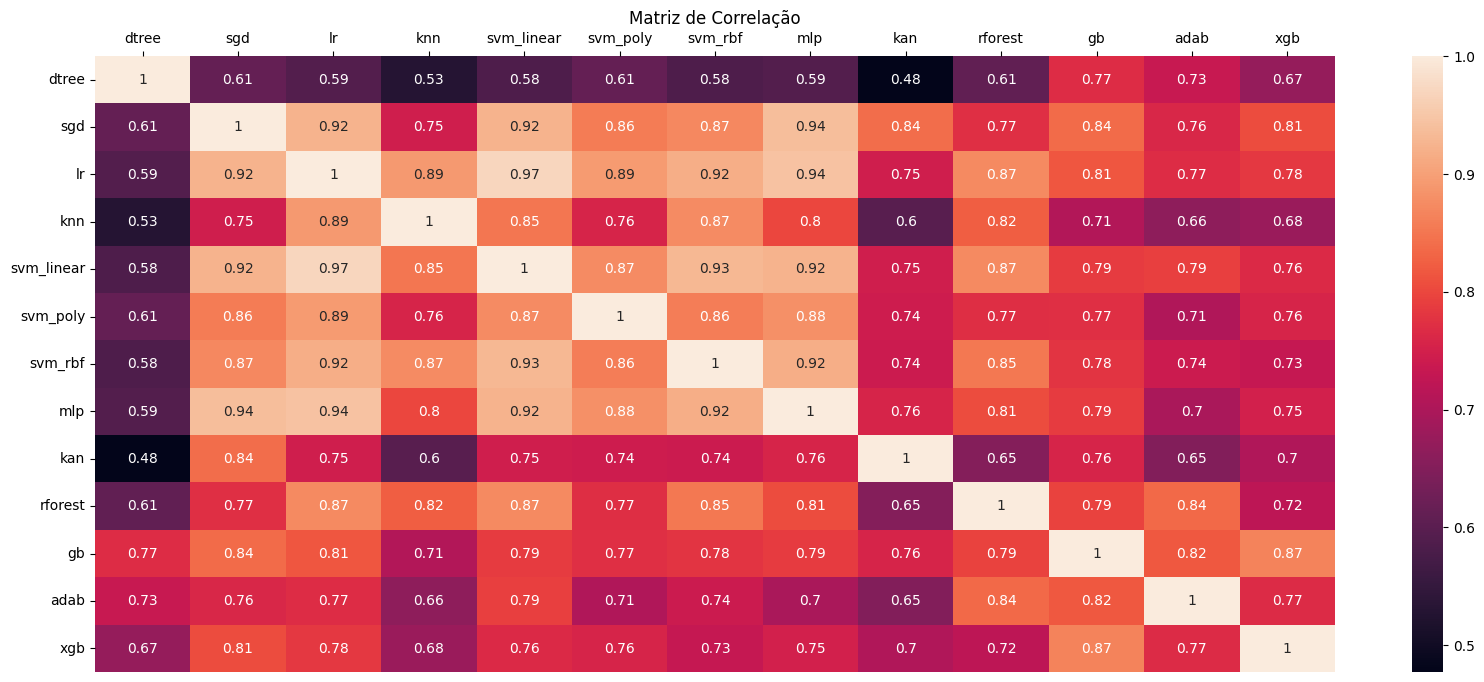

            corr
count  78.000000
mean    0.772680
std     0.105904
min     0.477328
25%     0.723297
50%     0.771528
75%     0.854491
max     0.969531


<Axes: >

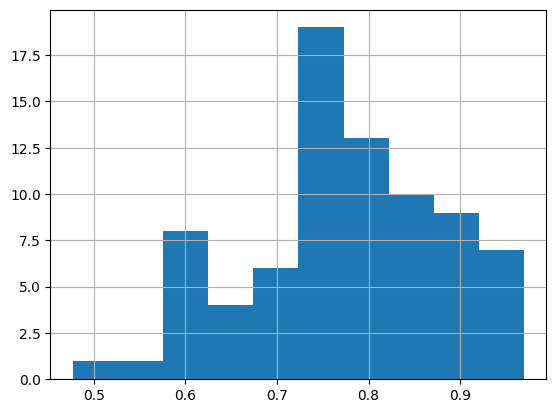

In [231]:
pred_corrls = models_error.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('Matriz de Correlação')
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show()

corrls_values = corrlArray(pred_corrls)

print(corrls_values[['corr']].describe())

corrls_values['corr'].hist()

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [232]:
def group_search_help(df: pd.DataFrame, min_score: int, models: list | set = None, base_group: list = []):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    if len(base_group) == 0:
        base_group, models = models[:1], models[1:]

    output_groups = []

    for m in models:
        check = True
        for bg in base_group:
            corr = df.at[bg, m]
            if np.isnan(corr) or corr < min_score:
                check = False
                break
        if check:
            temp = models.copy()
            temp.remove(m)
            output_groups.append(
                group_search_help(df, min_score, temp, base_group + [m])
            )

    if len(output_groups) == 0:
        return base_group

    return output_groups

def group_search(df: pd.DataFrame, min_score: int, models: list = None):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    # Corrige valores abaixo do min_score
    df = df.map(lambda x: np.nan if x < min_score else x)

    raw_groups = []
    for i in range(len(models)):
        raw_groups.append(group_search_help(df, min_score, models[i:]))

    return remove_subgroups(flatten_groups(raw_groups))
    
def flatten_groups(nested_list):
    flat_list = []

    def _flatten(item):
        if isinstance(item[0], list):
            for subitem in item:
                _flatten(subitem)
        else:
            flat_list.append(sorted(item))  # ordena para facilitar comparação de subconjuntos

    _flatten(nested_list)
    return flat_list

def remove_subgroups(groups:list):
    # Remove duplicatas (grupos com os mesmos elementos, em qualquer ordem)
    seen = set()
    unique_groups = []
    for g in groups:
        frozen = frozenset(g)
        if frozen not in seen:
            seen.add(frozen)
            unique_groups.append(g)

    # Agora removemos subconjuntos estritos
    filtered_groups = []
    for g in unique_groups:
        is_subset = False
        for other in unique_groups:
            if g != other and set(g).issubset(set(other)):
                is_subset = True
                break
        if not is_subset:
            filtered_groups.append(g)

    return filtered_groups

Pearson:

In [235]:
min_score = corrls_values['corr'].quantile(0.85)

print('Min_score:', min_score)

groups['true_assessor_train'] = group_search(pred_corrls, min_score)
groups['true_assessor_train']

Min_score: 0.8765766067136737


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr'],
 ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['lr', 'mlp', 'svm_poly'],
 ['kan'],
 ['rforest'],
 ['gb'],
 ['adab'],
 ['xgb']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [237]:
model_names = list(performs.keys())

Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.357143  0.240465  0.416048  0.470588    0.434321  0.412274  0.464318   
1  0.965517  0.646876  0.452941  0.294118    0.563983  0.699817  0.540896   
2  0.357143  0.733488  0.680125  0.705882    0.781501  0.454220  0.602347   
3  0.461538  0.050179  0.282246  0.411765    0.283095  0.363057  0.428255   
4  0.078947  0.607804  0.476185  0.352941    0.456514  0.520778  0.484935   

        mlp       kan   rforest        gb      adab       xgb  
0  0.306677  0.257097  0.347436  0.327406  0.453882  0.491934  
1  0.632825  0.674116  0.401496  0.724044  0.515561  0.846597  
2  0.485079  0.994194  0.652796  0.568036  0.561110  0.480499  
3  0.226214  0.000329  0.297672  0.193701  0.320892  0.085934  
4  0.622468  0.999975  0.287918  0.496492  0.330144  0.461939

In [238]:
Xa_train.head()

age  sex  chest_pain  blood_pressure  cholestoral  blood_sugar  \
76   59.0  1.0         3.0           126.0        218.0          1.0   
108  52.0  1.0         1.0           152.0        298.0          1.0   
16   65.0  1.0         1.0           138.0        282.0          1.0   
60   67.0  1.0         4.0           125.0        254.0          1.0   
187  65.0  0.0         3.0           160.0        360.0          0.0   

     eletro_results  max_heart_rate  exer_angina  oldpeak  slope_peak  \
76              0.0           134.0          0.0      2.2         2.0   
108             0.0           178.0          0.0      1.2         2.0   
16              2.0           174.0          0.0      1.4         2.0   
60              0.0           163.0          0.0      0.2         2.0   
187             2.0           151.0          0.0      0.8         1.0   

     major_vessels  thal  
76             1.0   6.0  
108            0.0   7.0  
16             1.0   3.0  
60             2.0   7.0  
187            0.0   3.0

In [239]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])
ya_test.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.034483  0.113134  0.205486  0.176471    0.147096  0.283670  0.074810   
1  0.034483  0.076642  0.172552  0.176471    0.186982  0.183808  0.101105   
2  0.921053  0.799683  0.663781  0.764706    0.714991  0.651247  0.874132   
3  0.921053  0.730773  0.514733  0.529412    0.500000  0.547081  0.493951   
4  0.461538  0.382534  0.572602  0.705882    0.445445  0.395322  0.513044   

        mlp       kan   rforest        gb      adab       xgb  
0  0.070668  0.000156  0.160674  0.151149  0.419960  0.028248  
1  0.082249  0.000785  0.226245  0.138091  0.261789  0.028824  
2  0.740503  0.997724  0.731392  0.794905  0.669856  0.924587  
3  0.571163  0.999630  0.652502  0.752282  0.580379  0.899618  
4  0.476932  0.883124  0.733779  0.602173  0.453933  0.751114

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

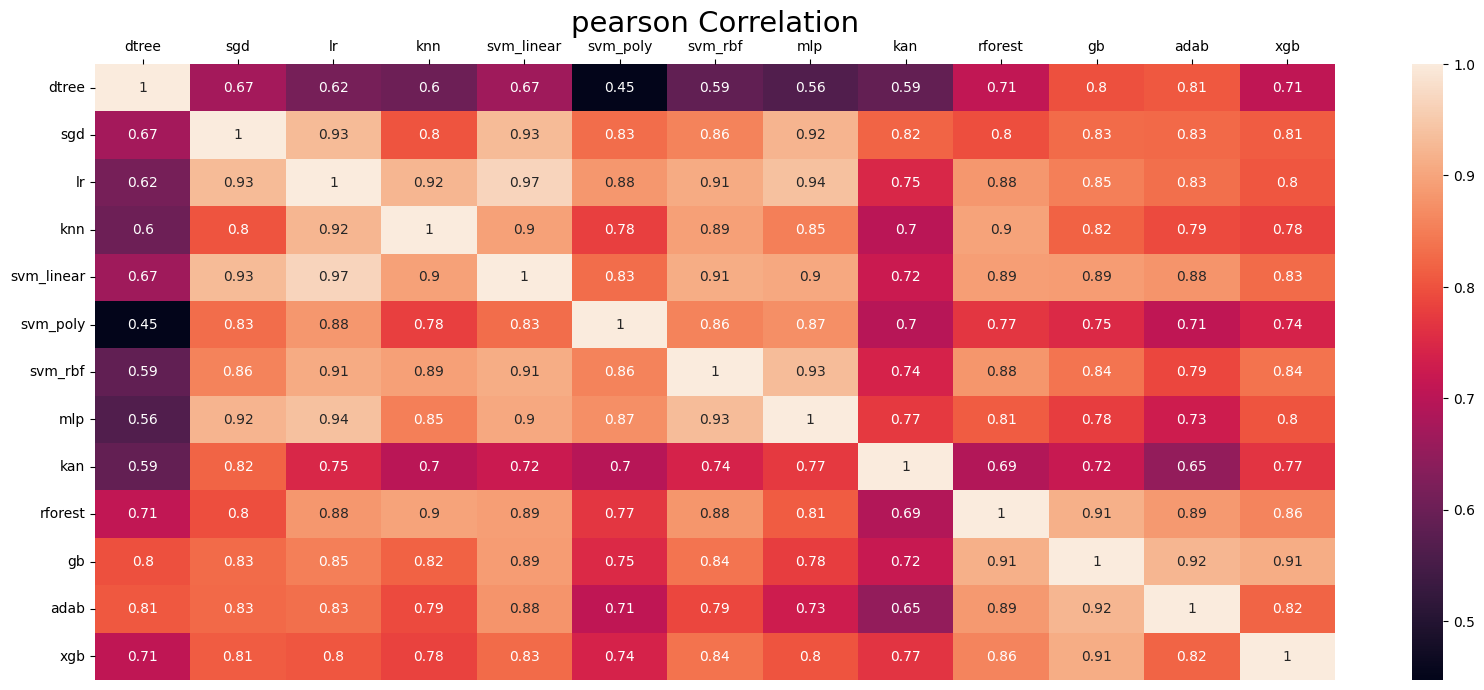

count    78.000000
mean      0.801869
std       0.102073
min       0.447267
25%       0.741197
50%       0.817905
75%       0.882621
max       0.967602
Name: corr, dtype: float64


<Axes: >

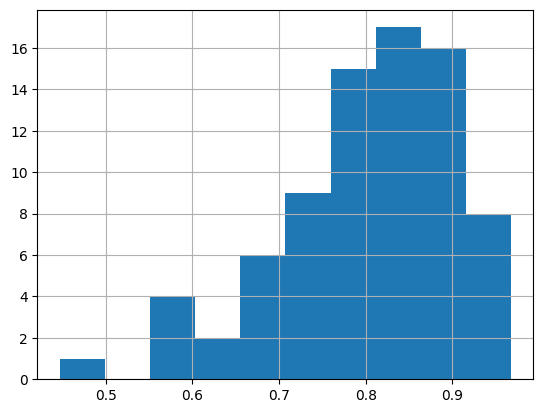

In [370]:
pred_corrls2 = ya_test.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values2 = corrlArray(pred_corrls2)['corr']
print(corrls_values2.describe())

corrls_values2.hist()

In [371]:
min_score2 = corrls_values2.quantile(0.75)

print('Min_score:', min_score2)

groups['true_assessor_test'] = group_search(pred_corrls2, min_score2)
groups['true_assessor_test']

Min_score: 0.8826210904342835


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr', 'svm_linear', 'svm_rbf'],
 ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['lr', 'svm_poly'],
 ['knn', 'rforest', 'svm_linear'],
 ['gb', 'rforest', 'svm_linear'],
 ['kan'],
 ['adab', 'gb', 'rforest'],
 ['gb', 'xgb']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: 0.0034
NMSE: 0.0581
MAE: 0.0435
NMSE: 0.3010


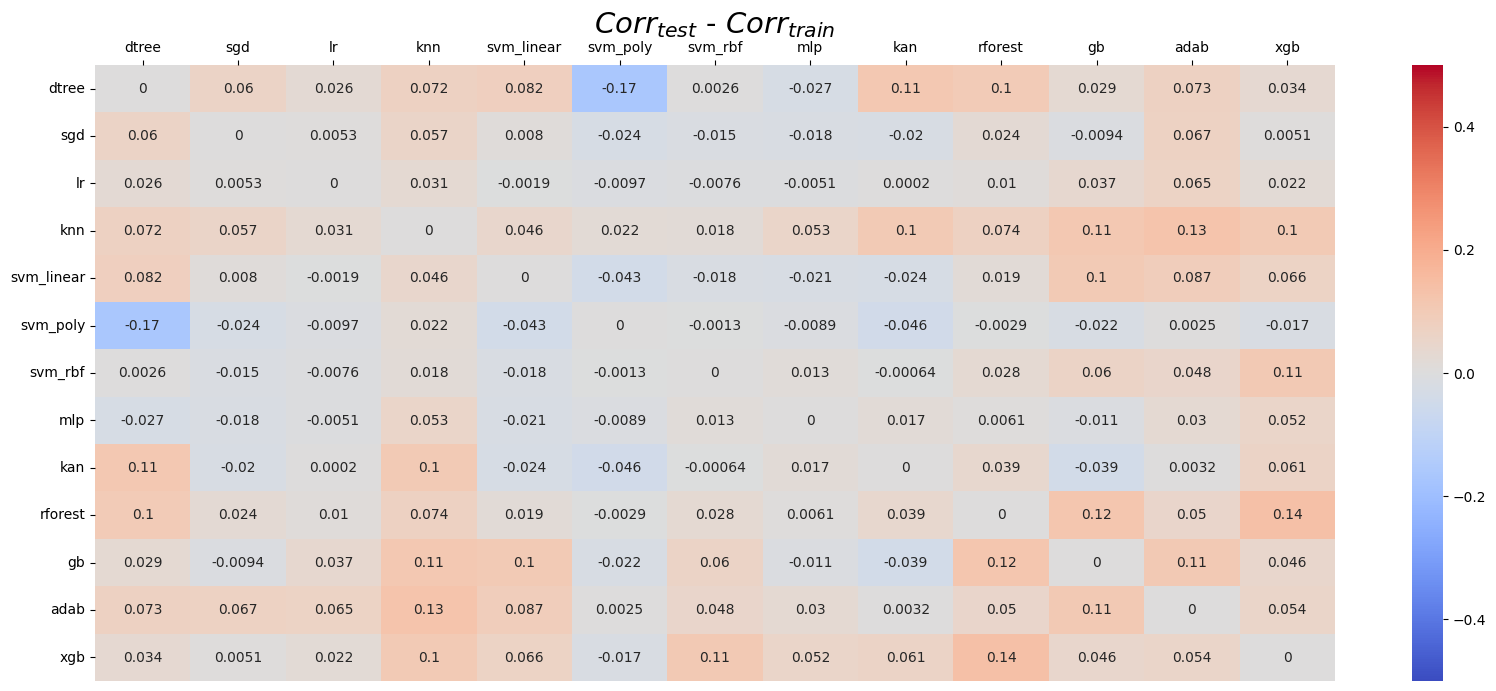

In [353]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = pred_corrls2-pred_corrls
# não adicionar isso em um eventual dataframe de métricas! 
# isso é só para ter uma ideia da diferença das relações de erro 
# conjunto de treinamento e teste. Não tem nada a ver com assessores
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls)['corr'].var():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

plt.show()

## Globais

### Regressor Chain
(RC)

In [245]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.1s
[Chain] .................. (2 of 13) Processing order 1, total=   0.1s
[Chain] .................. (3 of 13) Processing order 2, total=   0.1s
[Chain] .................. (4 of 13) Processing order 3, total=   0.1s
[Chain] .................. (5 of 13) Processing order 4, total=   0.1s
[Chain] .................. (6 of 13) Processing order 5, total=   0.1s
[Chain] .................. (7 of 13) Processing order 6, total=   0.1s
[Chain] .................. (8 of 13) Processing order 7, total=   0.1s
[Chain] .................. (9 of 13) Processing order 8, total=   0.1s
[Chain] ................. (10 of 13) Processing order 9, total=   0.1s
[Chain] ................ (11 of 13) Processing order 10, total=   0.1s
[Chain] ................ (12 of 13) Processing order 11, total=   0.1s
[Chain] ................ (13 of 13) Processing order 12, total=   0.2s


In [246]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
nmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [247]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['regchain',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0662
RMSE: 0.2493
MAE: 0.1929


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.091869  0.095054  0.044502  0.049034    0.050326  0.047354   
multi-output       NaN       NaN       NaN       NaN         NaN       NaN   
individual         NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.056144  0.074294  0.141202  0.039815  0.051366  0.014063   
multi-output       NaN       NaN       NaN       NaN       NaN       NaN   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.105586  
multi-output       NaN  
individual         NaN

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

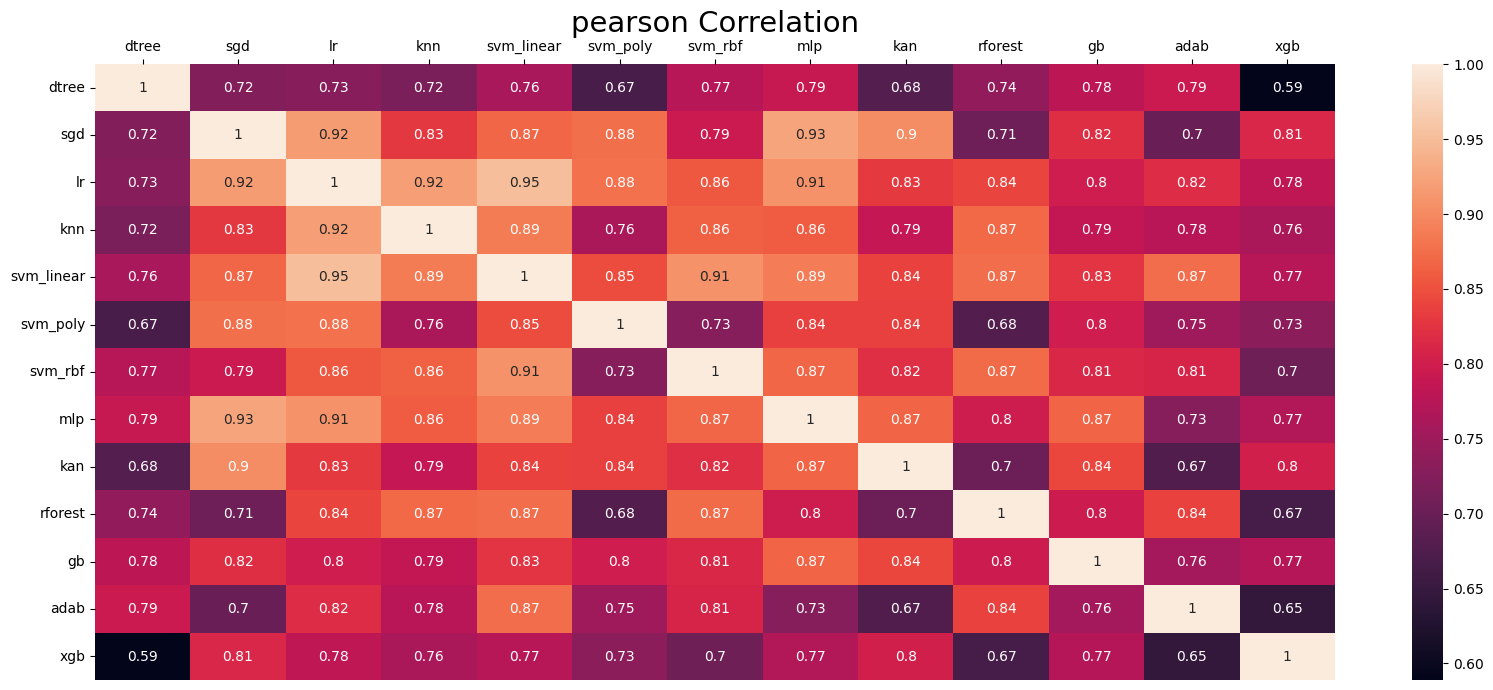

count    156.000000
mean       0.800321
std        0.074272
min        0.588948
25%        0.755362
50%        0.800367
75%        0.863023
max        0.951120
Name: corr, dtype: float64


<Axes: >

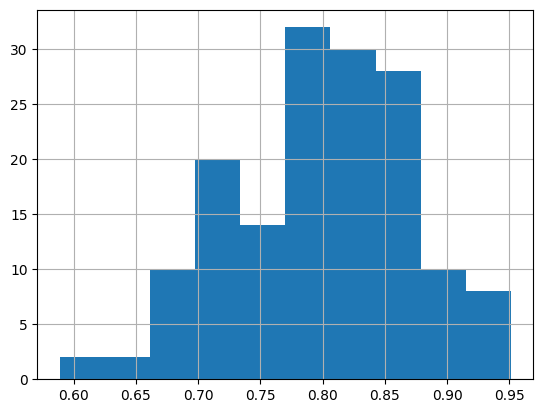

In [ ]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('pearson') 

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

regchain_corrls_values.hist()

In [323]:
min_score3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_train'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_train']

Min_score: 0.8630227929167231


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'sgd', 'svm_poly'],
 ['kan', 'mlp', 'sgd'],
 ['knn', 'lr', 'svm_linear'],
 ['knn', 'rforest', 'svm_linear', 'svm_rbf'],
 ['mlp', 'svm_linear', 'svm_rbf'],
 ['adab', 'svm_linear'],
 ['gb', 'mlp'],
 ['xgb']]

Conjunto de Teste:

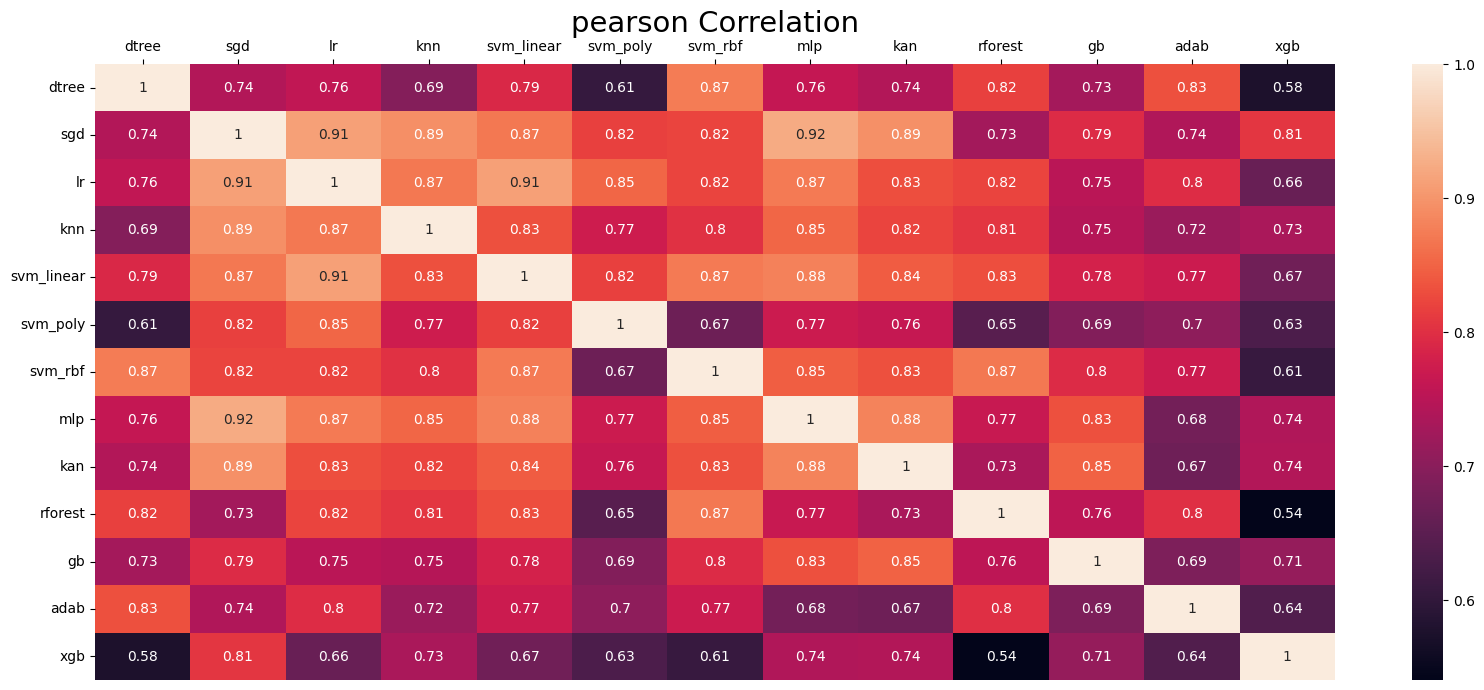

count    156.000000
mean       0.775474
std        0.083470
min        0.540388
25%        0.728856
50%        0.786608
75%        0.831903
max        0.924315
Name: corr, dtype: float64


<Axes: >

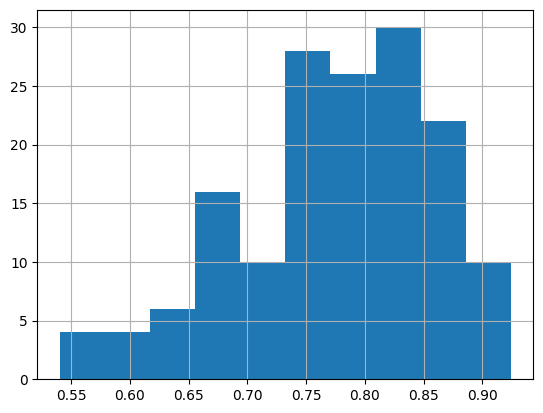

In [324]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

regchain_corrls_values.hist()

In [325]:
min_score3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_test'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_test']

Min_score: 0.8319034154824939


[['dtree', 'svm_rbf'],
 ['adab', 'dtree'],
 ['knn', 'lr', 'mlp', 'sgd', 'svm_linear'],
 ['kan', 'mlp', 'sgd', 'svm_linear'],
 ['lr', 'svm_poly'],
 ['mlp', 'svm_linear', 'svm_rbf'],
 ['rforest', 'svm_rbf'],
 ['gb', 'kan'],
 ['xgb']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0118
NMSE: 0.1085
MAE: 0.0872
NMSE: 1.1368
Desvio Padrão: 0.1056


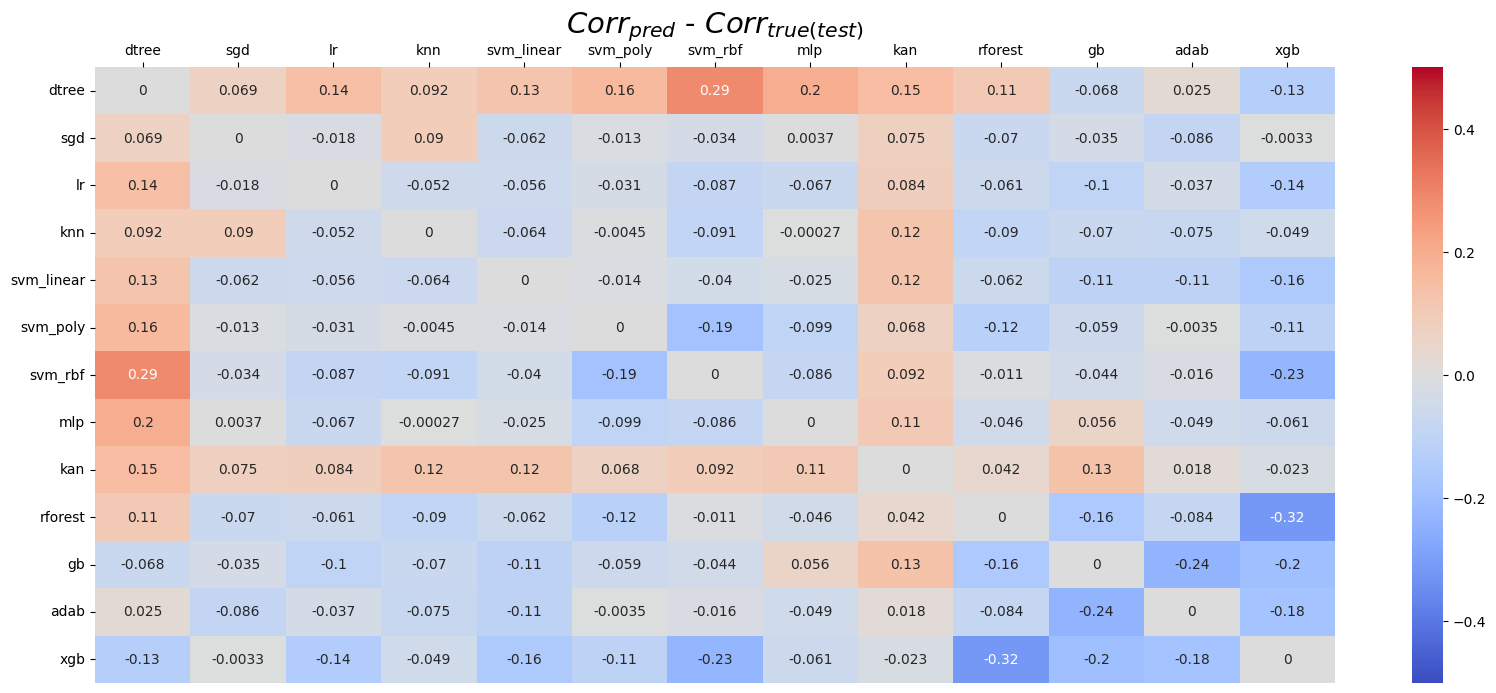

<Axes: >

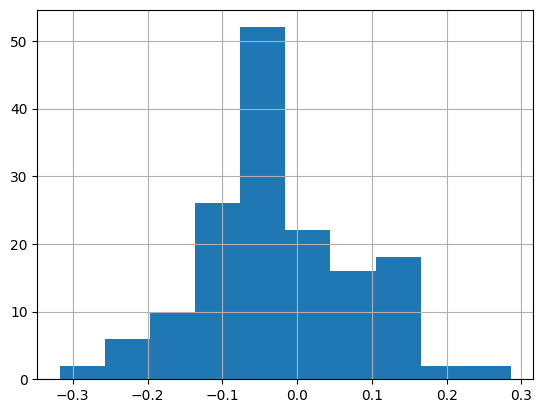

In [338]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = regchain_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

plt.show(hm)

diff_corrls_values.hist()

In [344]:
pred_corrls

dtree       sgd        lr       knn  svm_linear  svm_poly  \
dtree       1.000000  0.613144  0.589830  0.529526    0.583890  0.613451   
sgd         0.613144  1.000000  0.923831  0.745339    0.922774  0.855130   
lr          0.589830  0.923831  1.000000  0.891452    0.969531  0.892515   
knn         0.529526  0.745339  0.891452  1.000000    0.849824  0.756238   
svm_linear  0.583890  0.922774  0.969531  0.849824    1.000000  0.874027   
svm_poly    0.613451  0.855130  0.892515  0.756238    0.874027  1.000000   
svm_rbf     0.584374  0.870971  0.916804  0.873857    0.929104  0.857193   
mlp         0.591487  0.938699  0.944037  0.799006    0.924331  0.879692   
kan         0.477328  0.839332  0.746286  0.596738    0.745830  0.741912   
rforest     0.609094  0.772729  0.871835  0.823045    0.873300  0.770327   
gb          0.768144  0.837940  0.814506  0.707095    0.786151  0.772901   
adab        0.733452  0.759207  0.768379  0.663332    0.790885  0.705898   
xgb         0.673123  0.805836  0.781852  0.678865    0.763365  0.756319   

             svm_rbf       mlp       kan   rforest        gb      adab  \
dtree       0.584374  0.591487  0.477328  0.609094  0.768144  0.733452   
sgd         0.870971  0.938699  0.839332  0.772729  0.837940  0.759207   
lr          0.916804  0.944037  0.746286  0.871835  0.814506  0.768379   
knn         0.873857  0.799006  0.596738  0.823045  0.707095  0.663332   
svm_linear  0.929104  0.924331  0.745830  0.873300  0.786151  0.790885   
svm_poly    0.857193  0.879692  0.741912  0.770327  0.772901  0.705898   
svm_rbf     1.000000  0.917945  0.740076  0.852575  0.779189  0.739001   
mlp         0.917945  1.000000  0.755994  0.805882  0.786660  0.696106   
kan         0.740076  0.755994  1.000000  0.651924  0.756503  0.648934   
rforest     0.852575  0.805882  0.651924  1.000000  0.793834  0.835478   
gb          0.779189  0.786660  0.756503  0.793834  1.000000  0.816370   
adab        0.739001  0.696106  0.648934  0.835478  0.816370  1.000000   
xgb         0.731491  0.749591  0.704411  0.720565  0.865232  0.766236   

                 xgb  
dtree       0.673123  
sgd         0.805836  
lr          0.781852  
knn         0.678865  
svm_linear  0.763365  
svm_poly    0.756319  
svm_rbf     0.731491  
mlp         0.749591  
kan         0.704411  
rforest     0.720565  
gb          0.865232  
adab        0.766236  
xgb         1.000000

### Multi-Output Regressor 
(ST)

In [257]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [258]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-output',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0695
RMSE: 0.2546
MAE: 0.1973


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.091869  0.095054  0.044502  0.049034    0.050326  0.047354   
multi-output  0.091869  0.101041  0.046417  0.049038    0.052488  0.048239   
individual         NaN       NaN       NaN       NaN         NaN       NaN   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.056144  0.074294  0.141202  0.039815  0.051366  0.014063   
multi-output  0.057535  0.077597  0.165216  0.044409  0.053412  0.013986   
individual         NaN       NaN       NaN       NaN       NaN       NaN   

                   xgb  
regchain      0.105586  
multi-output  0.101638  
individual         NaN

#### Análise das correlações

Conjunto de Treinamento:

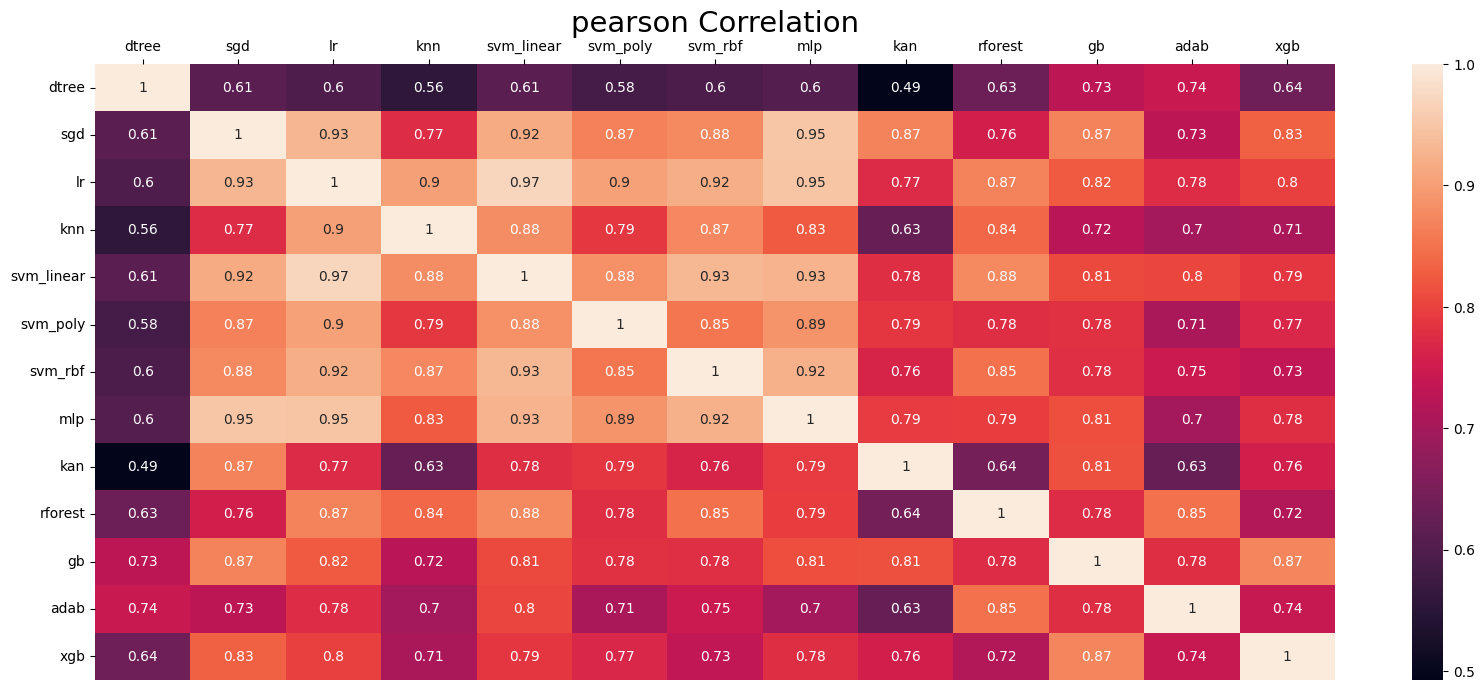

count    78.000000
mean      0.782107
std       0.105355
min       0.492795
25%       0.730304
50%       0.784078
75%       0.867756
max       0.971549
Name: corr, dtype: float64


<Axes: >

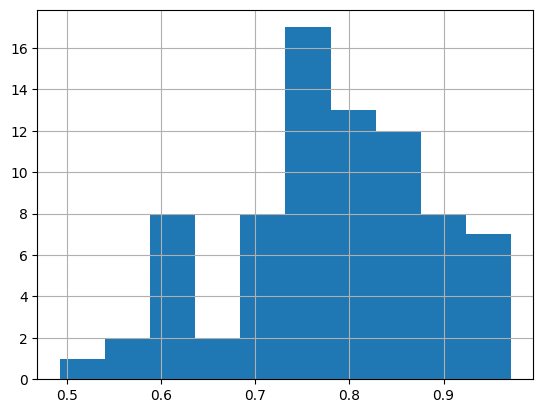

In [360]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('pearson')

plt.figure(figsize=(20,8))
plt.title(r'pearson Correlation', fontsize=21)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

mor_corrls_values.hist()

In [361]:
min_score4 = mor_corrls_values.quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_train'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_train']

Min_score: 0.8677563251379954


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
 ['gb', 'sgd'],
 ['knn', 'lr', 'svm_linear', 'svm_rbf'],
 ['lr', 'mlp', 'svm_linear', 'svm_poly'],
 ['lr', 'rforest', 'svm_linear'],
 ['kan'],
 ['gb', 'xgb'],
 ['adab']]

Conjunto de Teste:

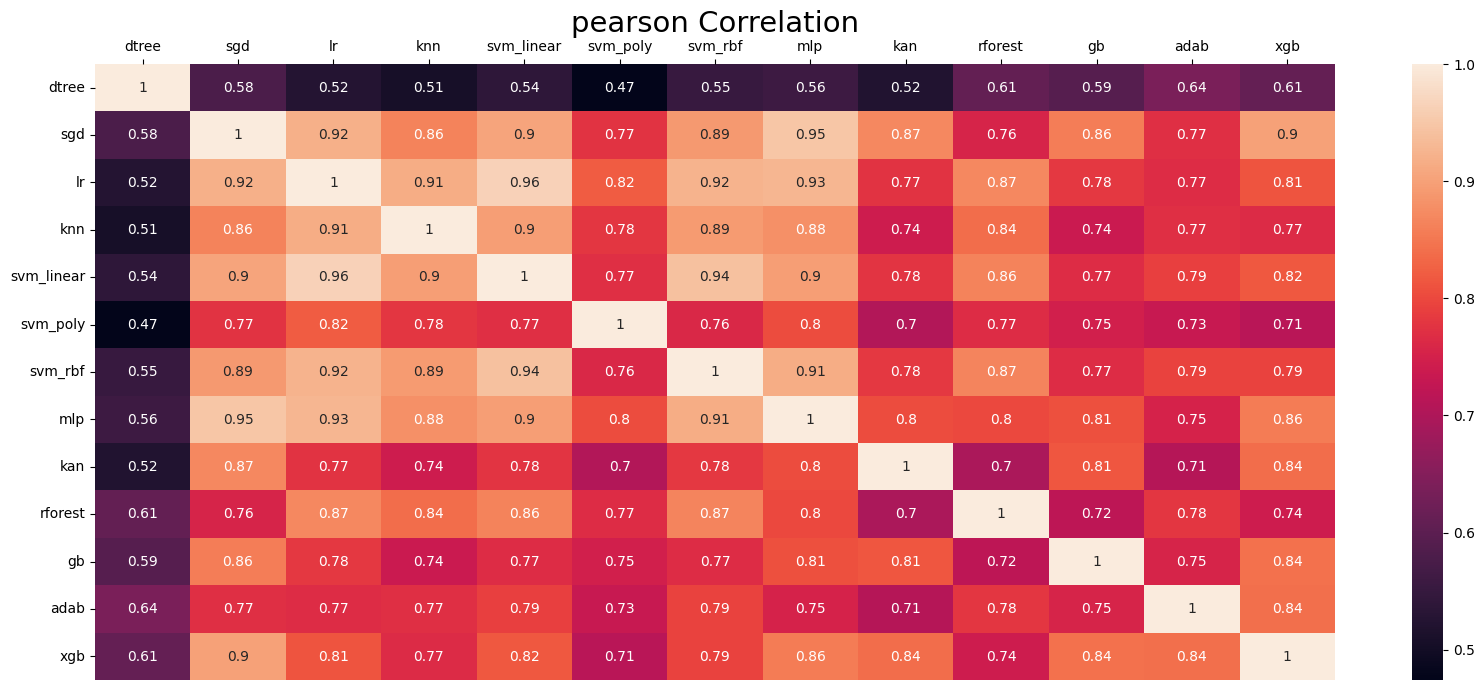

count    78.000000
mean      0.776024
std       0.113900
min       0.474139
25%       0.739570
50%       0.780074
75%       0.862287
max       0.963954
Name: corr, dtype: float64


<Axes: >

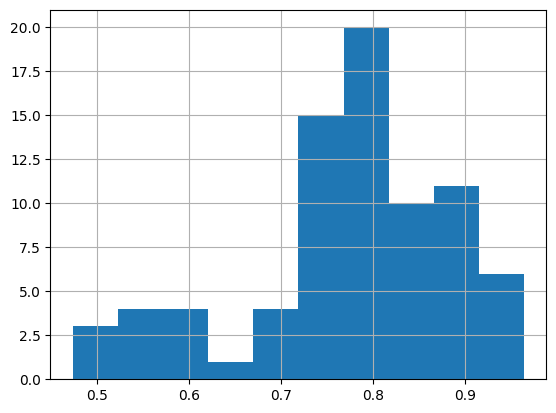

In [362]:
mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('pearson')

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

mor_corrls_values.hist()

In [363]:
min_score4 = mor_corrls_values.quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_test'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_test']

Min_score: 0.8622871913827246


[['dtree'],
 ['knn', 'lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'sgd'],
 ['sgd', 'xgb'],
 ['lr', 'rforest', 'svm_linear', 'svm_rbf'],
 ['svm_poly'],
 ['gb'],
 ['adab']]

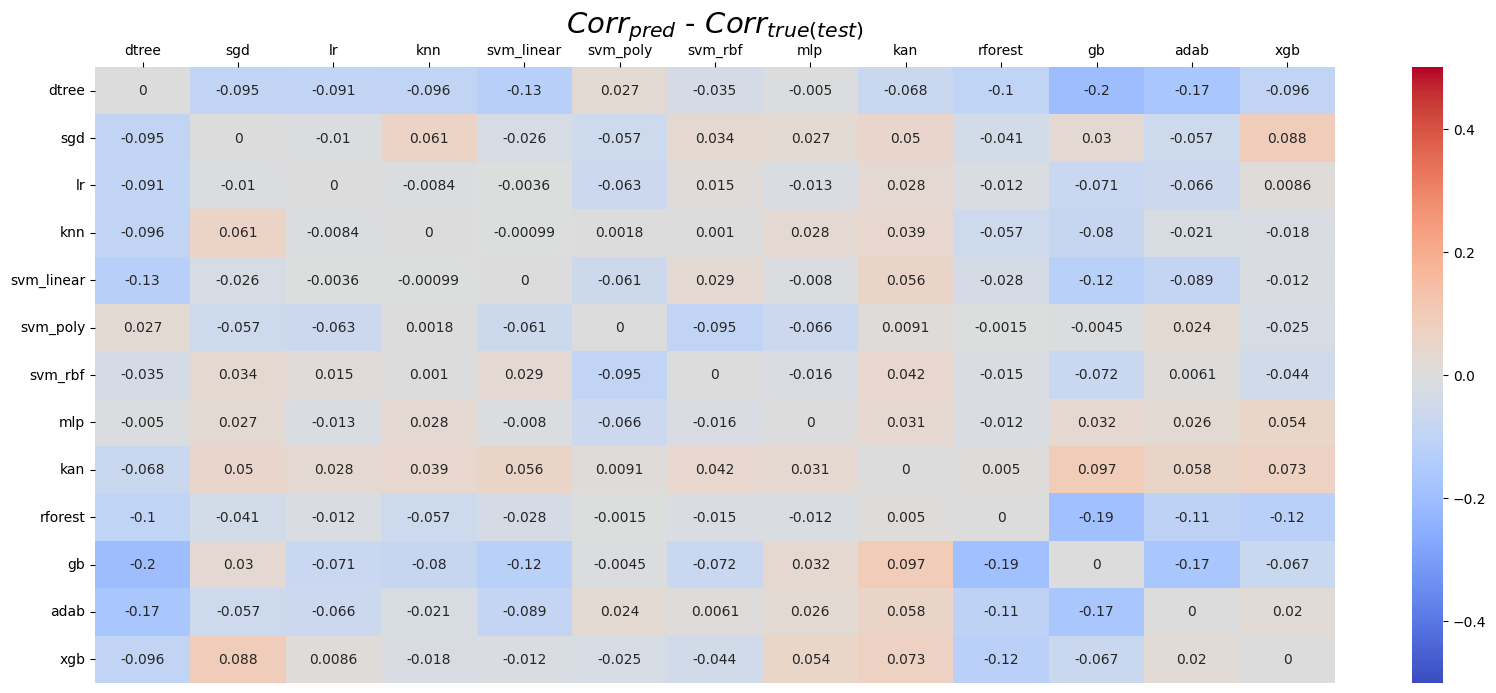

<Axes: >

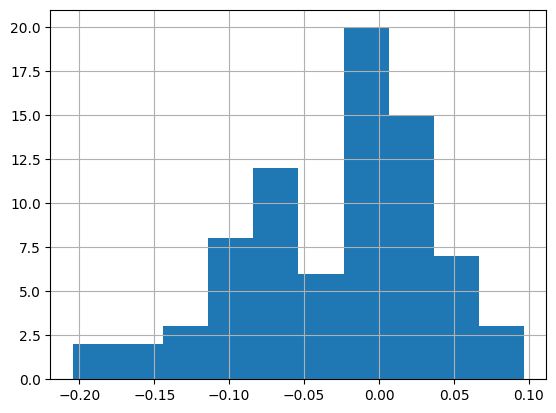

In [364]:
pred_corrls2 = ya_test.corr('pearson')
diff_corrls = mor_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

plt.show(hm)

diff_corrls_values.hist()

## Individuais

In [268]:
ind_assessors = {}
parameters['criterion'] = ['squared_error', 'poisson', 'friedman_mse']

for i in range(len(models)):
    g_search = GridSearchCV(RandomForestRegressor(random_state=seed), parameters, cv=5, n_jobs=-1)
    ind_assessors[model_names[i]] = g_search.fit(Xa_train, ya_train[model_names[i]]).best_estimator_
    print(f'[Assessor {i}] | Modelo Base: {model_names[i]} | Parâmetros: {g_search.best_params_}\nScore: {g_search.best_score_:.4f}\n')

[Assessor 0] | Modelo Base: dtree | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Score: 0.0275

[Assessor 1] | Modelo Base: sgd | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Score: 0.1352

[Assessor 2] | Modelo Base: lr | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Score: 0.1376

[Assessor 3] | Modelo Base: knn | Parâmetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}
Score: -0.0005

[Assessor 4] | Modelo Base: svm_linear | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Score: 0.1131

[Assessor 5] | Modelo Base: svm_poly | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_

In [269]:
metrics_indv = {'MSE':[], 'RMSE':[], 'MAE':[], 'NMSE':[]}

for m in model_names:
    y_pred = ind_assessors[m].predict(Xa_test)

    # Cálculo das métricas
    metrics_indv['MSE'].append(mse(ya_test[m], y_pred))
    metrics_indv['RMSE'].append(rmse(ya_test[m], y_pred))
    metrics_indv['MAE'].append(mae(ya_test[m], y_pred))
    metrics_indv['NMSE'].append(nmse(ya_test[m], y_pred))


    mse_df.at['individual',m] = mse(ya_test[m], y_pred)
    rmse_df.at['individual',m] = rmse(ya_test[m], y_pred)
    mae_df.at['individual',m] = mae(ya_test[m], y_pred)
    nmse_df.at['individual',m] = nmse(ya_test[m], y_pred)

for k in metrics_indv.keys():
    print(f'''{k}:
    - Média: {np.mean(metrics_indv[k]):.4f}
    - DP:    {np.std(metrics_indv[k]):.4f}''')

mse_df

MSE:
    - Média: 0.0672
    - DP:    0.0346
RMSE:
    - Média: 0.2510
    - DP:    0.0649
MAE:
    - Média: 0.1963
    - DP:    0.0519
NMSE:
    - Média: 1.0206
    - DP:    0.0983


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain      0.091869  0.095054  0.044502  0.049034    0.050326  0.047354   
multi-output  0.091869  0.101041  0.046417  0.049038    0.052488  0.048239   
individual    0.093350  0.099630  0.047054  0.047498    0.051777  0.048239   

               svm_rbf       mlp       kan   rforest        gb      adab  \
regchain      0.056144  0.074294  0.141202  0.039815  0.051366  0.014063   
multi-output  0.057535  0.077597  0.165216  0.044409  0.053412  0.013986   
individual    0.058037  0.075613  0.158065  0.042937  0.051087  0.014314   

                   xgb  
regchain      0.105586  
multi-output  0.101638  
individual    0.086256

#### Análise das correlações

Conjunto de Treinamento:

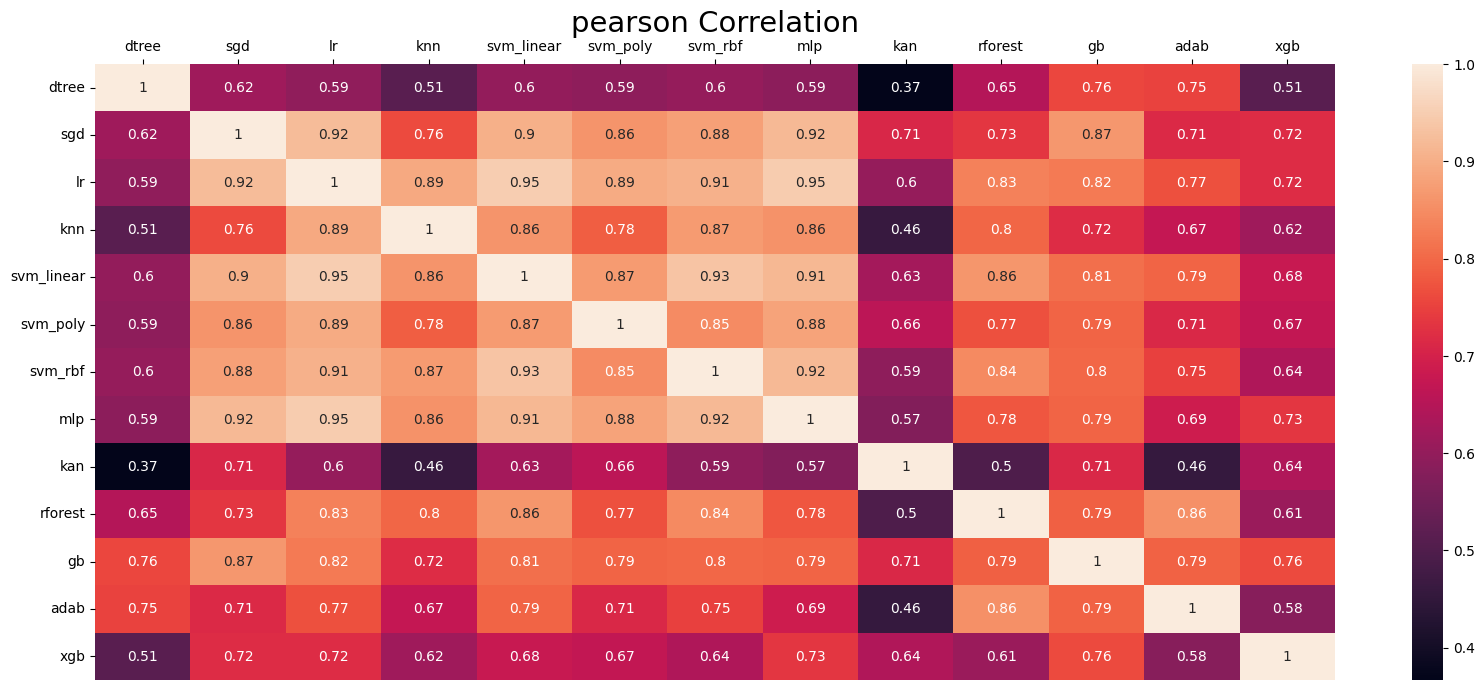

count    78.000000
mean      0.740093
std       0.132431
min       0.366871
25%       0.640975
50%       0.759021
75%       0.857710
max       0.948844
Name: corr, dtype: float64


<Axes: >

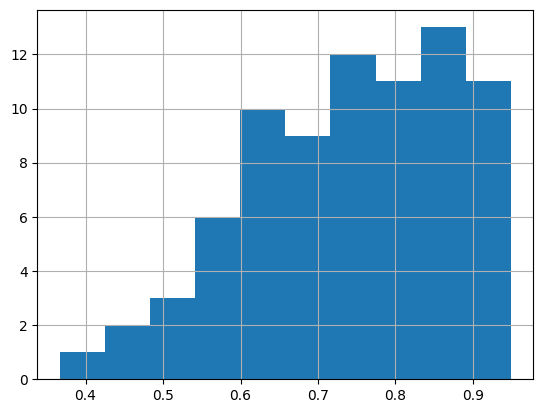

In [366]:
#y_pred = pd.DataFrame(columns=model_names)

indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_train.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_train)

indass_corrls = indass_corrls.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

indass_corrls_values = corrlArray(indass_corrls)['corr']
print(indass_corrls_values.describe())

indass_corrls_values.hist()

In [367]:
min_score5 = indass_corrls_values.quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_train'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_train']

Min_score: 0.8577103406956441


[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_poly'],
 ['lr', 'mlp', 'sgd', 'svm_linear', 'svm_rbf'],
 ['gb', 'sgd'],
 ['knn', 'lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['rforest', 'svm_linear'],
 ['kan'],
 ['adab'],
 ['xgb']]

Conjunto de Teste:

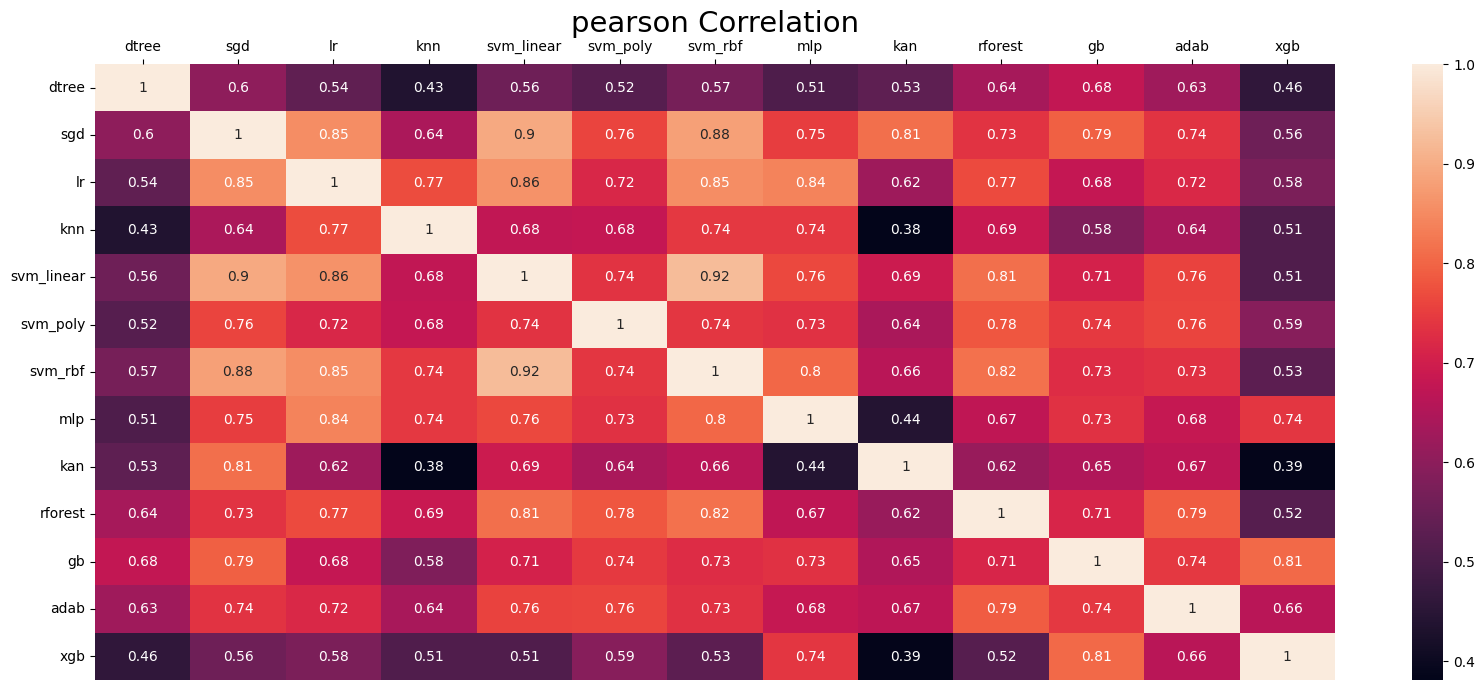

count    78.000000
mean      0.680866
std       0.120602
min       0.381139
25%       0.605887
50%       0.699318
75%       0.758271
max       0.924991
Name: corr, dtype: float64


<Axes: >

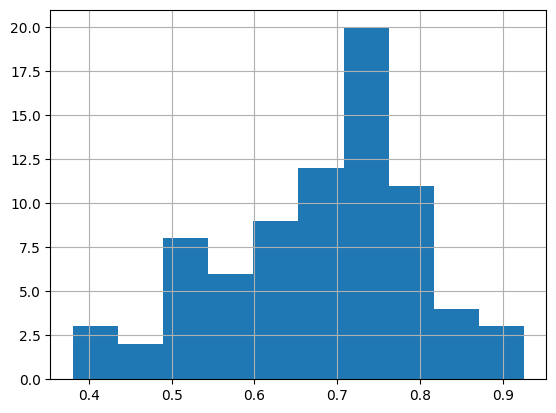

In [369]:
indass_corrls = pd.DataFrame(columns=model_names, 
                             index=Xa_test.index, dtype=float)

for m in model_names:
    indass_corrls[m] = ind_assessors[m].predict(Xa_test)

indass_corrls = indass_corrls.corr('pearson')
plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

indass_corrls_values = corrlArray(indass_corrls)['corr']
print(indass_corrls_values.describe())

indass_corrls_values.hist()

In [277]:
min_score5 = indass_corrls_values.quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_test'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_test']

Min_score: 0.7808045632388372


[['dtree'],
 ['lr', 'sgd', 'svm_linear', 'svm_rbf'],
 ['kan', 'sgd'],
 ['gb', 'sgd'],
 ['lr', 'mlp', 'svm_rbf'],
 ['knn'],
 ['rforest', 'svm_linear', 'svm_rbf'],
 ['rforest', 'svm_poly'],
 ['adab', 'rforest'],
 ['gb', 'xgb']]

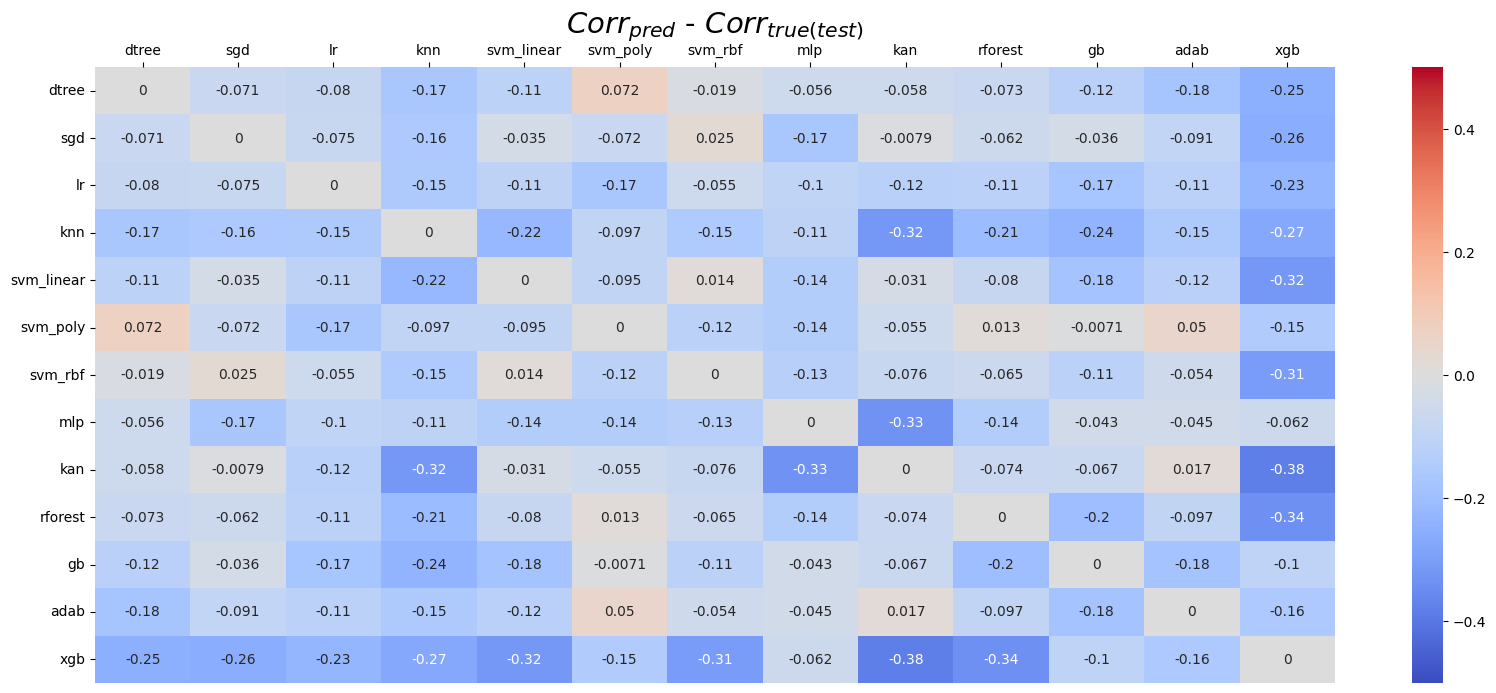

In [278]:
#pred_corrls2 = ya_test.corr('pearson')
diff_corrls = indass_corrls - pred_corrls2

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()

## Grupais

In [372]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(10) & true_assessor_test(10):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear']
['lr', 'mlp', 'svm_linear', 'svm_rbf']
['kan']
Número de grupos em comum: 4


true_assessor_train(10) & regchain_assessor_train(10):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear']
['xgb']
Número de grupos em comum: 3


true_assessor_train(10) & regchain_assessor_test(9):
['xgb']
Número de grupos em comum: 1


true_assessor_train(10) & mor_assessor_train(9):
['dtree']
['kan']
['adab']
Número de grupos em comum: 3


true_assessor_train(10) & mor_assessor_test(8):
['dtree']
['gb']
['adab']
Número de grupos em comum: 3


true_assessor_train(10) & indv_assessor_train(9):
['dtree']
['kan']
['adab']
['xgb']
Número de grupos em comum: 4


true_assessor_train(10) & indv_assessor_test(10):
['dtree']
Número de grupos em comum: 1


true_assessor_test(10) & regchain_assessor_train(10):
['dtree']
['lr', 'mlp', 'sgd', 'svm_linear']
Número de grupos em comum: 2


true_assessor_test(10) & regchain_assessor_test

In [374]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['lr', 'mlp', 'sgd', 'svm_linear']
total: 0.9372002961374616

['knn', 'lr']
total: 0.8914519065339906

['lr', 'mlp', 'svm_linear', 'svm_rbf']
total: 0.9336252409144543

['lr', 'mlp', 'svm_poly']
total: 0.9054146531022194



In [282]:
groups

{'true_assessor_train': [['dtree'],
  ['lr', 'mlp', 'sgd', 'svm_linear'],
  ['knn', 'lr'],
  ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
  ['lr', 'mlp', 'svm_poly'],
  ['kan'],
  ['rforest'],
  ['gb'],
  ['adab'],
  ['xgb']],
 'true_assessor_test': [['dtree'],
  ['lr', 'mlp', 'sgd', 'svm_linear'],
  ['knn', 'lr', 'svm_linear'],
  ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
  ['knn', 'rforest'],
  ['svm_poly'],
  ['kan'],
  ['gb', 'rforest'],
  ['adab', 'gb'],
  ['gb', 'xgb']],
 'regchain_assessor_train': [['dtree'],
  ['lr', 'sgd', 'svm_poly'],
  ['lr', 'mlp', 'sgd'],
  ['kan', 'sgd'],
  ['knn', 'lr', 'svm_linear'],
  ['lr', 'mlp', 'svm_linear'],
  ['knn', 'rforest', 'svm_linear'],
  ['rforest', 'svm_linear', 'svm_rbf'],
  ['adab', 'svm_linear'],
  ['gb'],
  ['xgb']],
 'regchain_assessor_test': [['dtree', 'svm_rbf'],
  ['knn', 'lr', 'mlp', 'sgd'],
  ['lr', 'mlp', 'sgd', 'svm_linear'],
  ['kan', 'mlp', 'sgd'],
  ['lr', 'svm_poly'],
  ['svm_linear', 'svm_rbf'],
  ['rforest', 'svm_rbf'],
  ['gb']

In [283]:
groups['true_assessor_train']

[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr'],
 ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['lr', 'mlp', 'svm_poly'],
 ['kan'],
 ['rforest'],
 ['gb'],
 ['adab'],
 ['xgb']]

In [375]:
groups['true_assessor_test']

[['dtree'],
 ['lr', 'mlp', 'sgd', 'svm_linear'],
 ['knn', 'lr', 'svm_linear', 'svm_rbf'],
 ['lr', 'mlp', 'svm_linear', 'svm_rbf'],
 ['lr', 'svm_poly'],
 ['knn', 'rforest', 'svm_linear'],
 ['gb', 'rforest', 'svm_linear'],
 ['kan'],
 ['adab', 'gb', 'rforest'],
 ['gb', 'xgb']]

### Regressor Chain

In [285]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [356]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0678
RMSE: 0.2516
MAE: 0.1958
NMSE: 1.0200


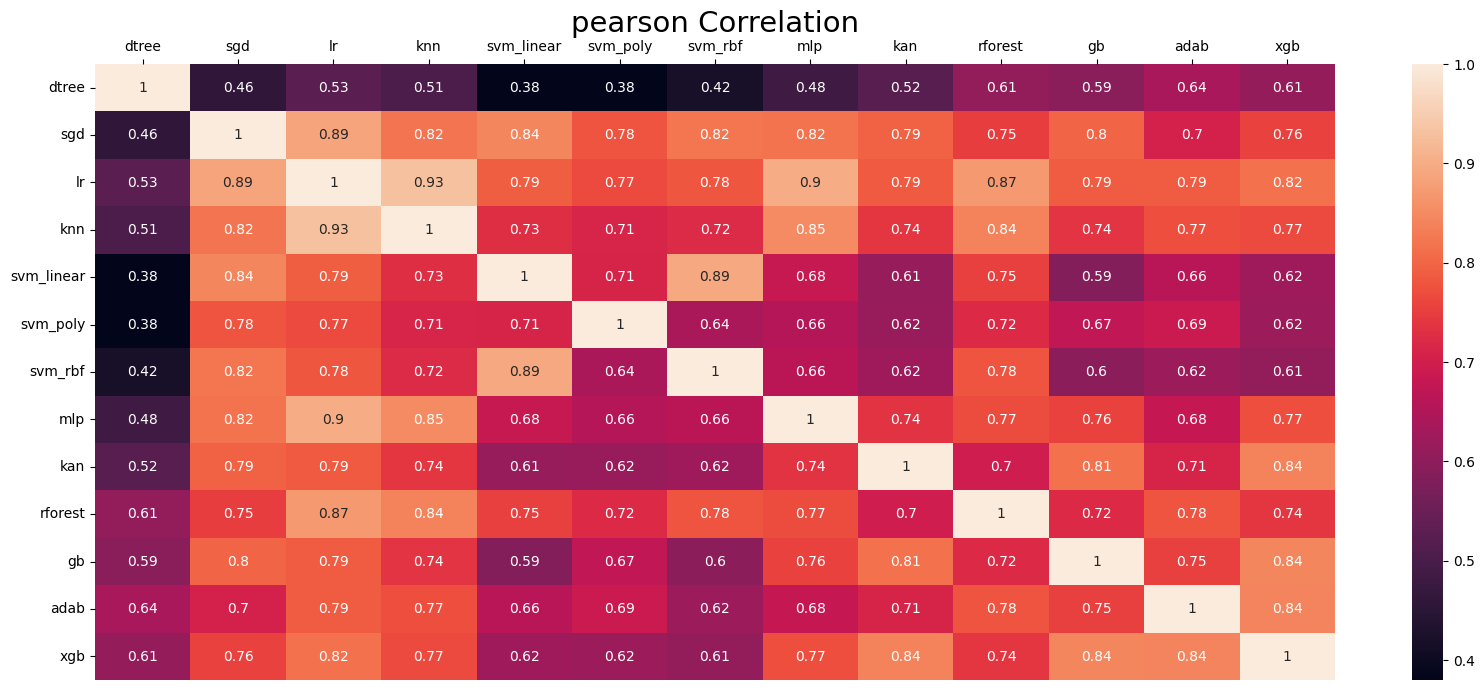

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0156
NMSE: 0.1248
MAE: 0.1002
NMSE: 1.4955
Desvio Padrão: 0.0863


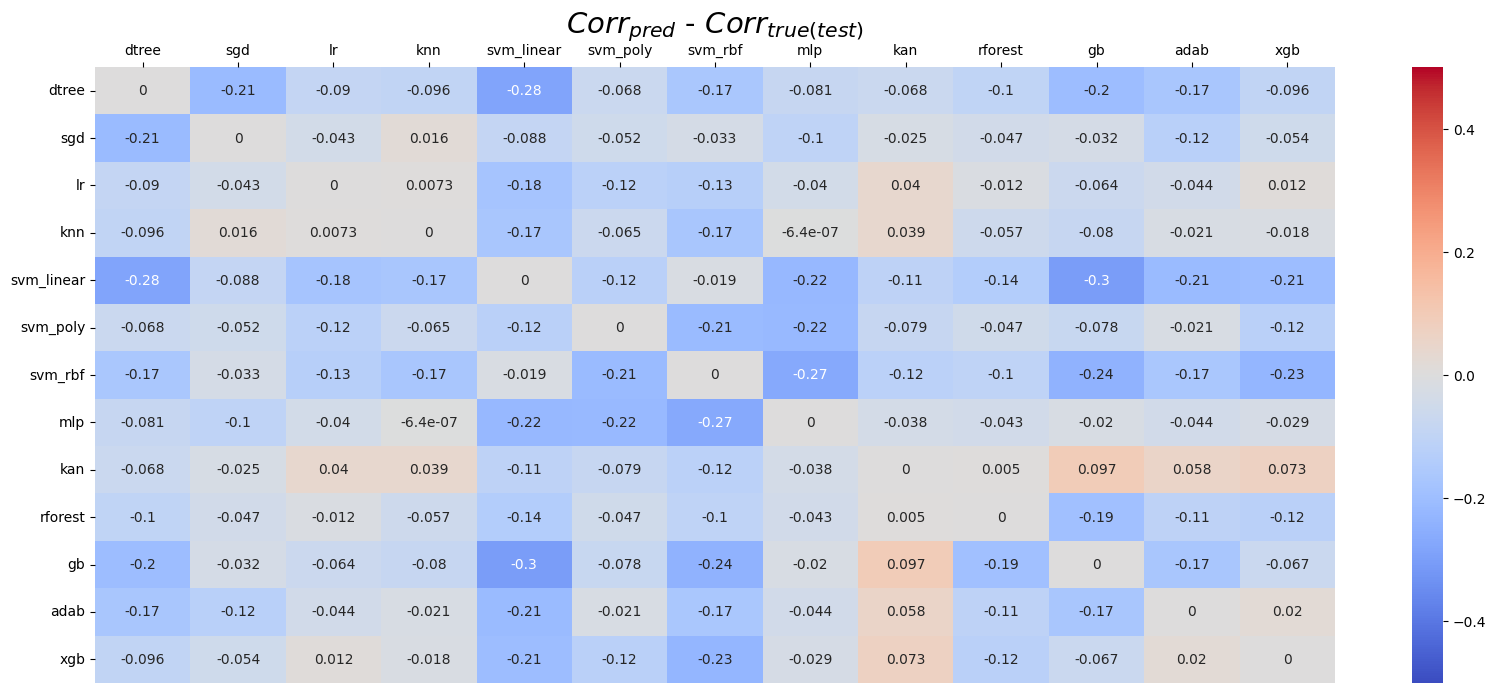

In [357]:
regchainGroups_corrls = y_pred.corr('pearson')
pred_corrls2 = ya_test.corr('pearson')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['regchain(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['regchain(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['regchain(group)',:] = nmse_models(ya_test, y_pred)


plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(regchainGroups_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls = regchainGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

### Multi-Output Regressor

In [289]:
mor4groups = []

for g in groups['true_assessor_train']:
    model = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train[g])
    mor4groups.append(model)

In [358]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mor4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

In [377]:
len(cols)

13

MSE: 0.0695
RMSE: 0.2546
MAE: 0.1973
NMSE: 1.0450


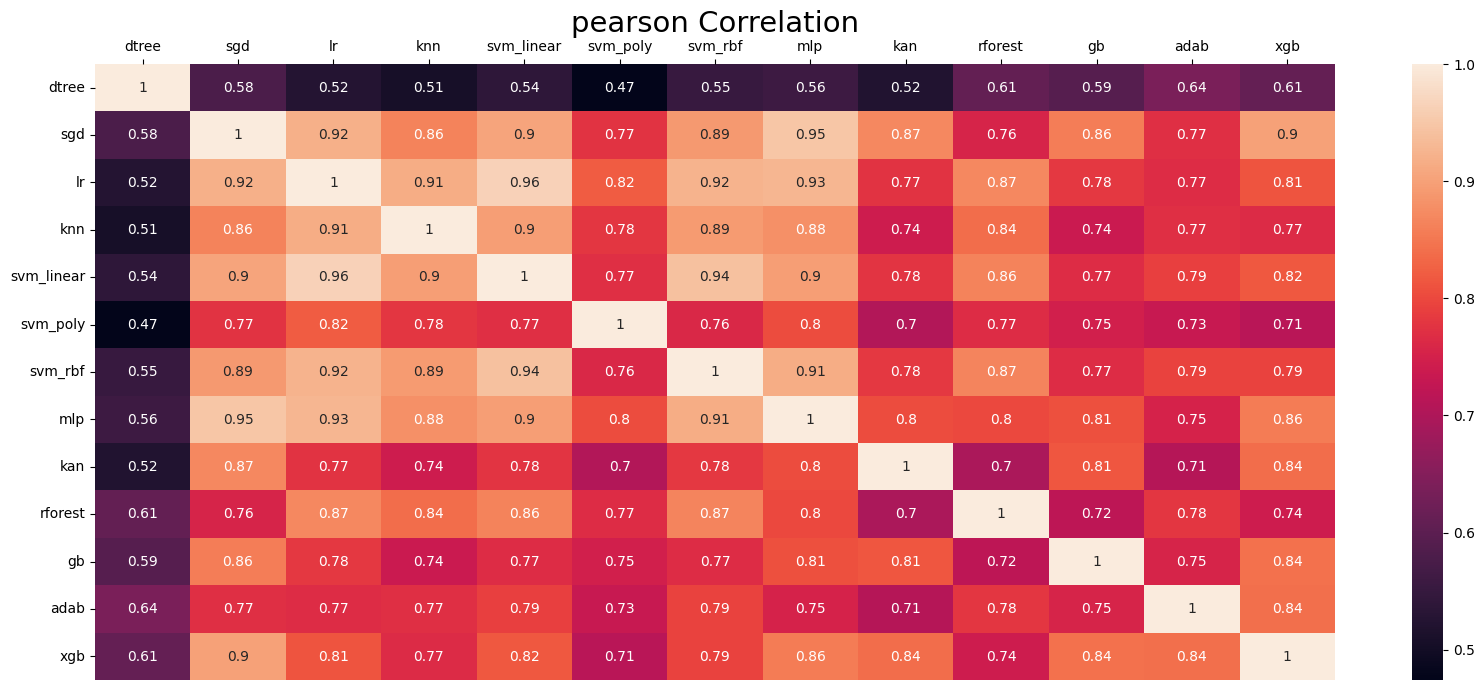

Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: 0.0047
NMSE: 0.0687
MAE: 0.0515
NMSE: 0.4533
Desvio Padrão: 0.0641


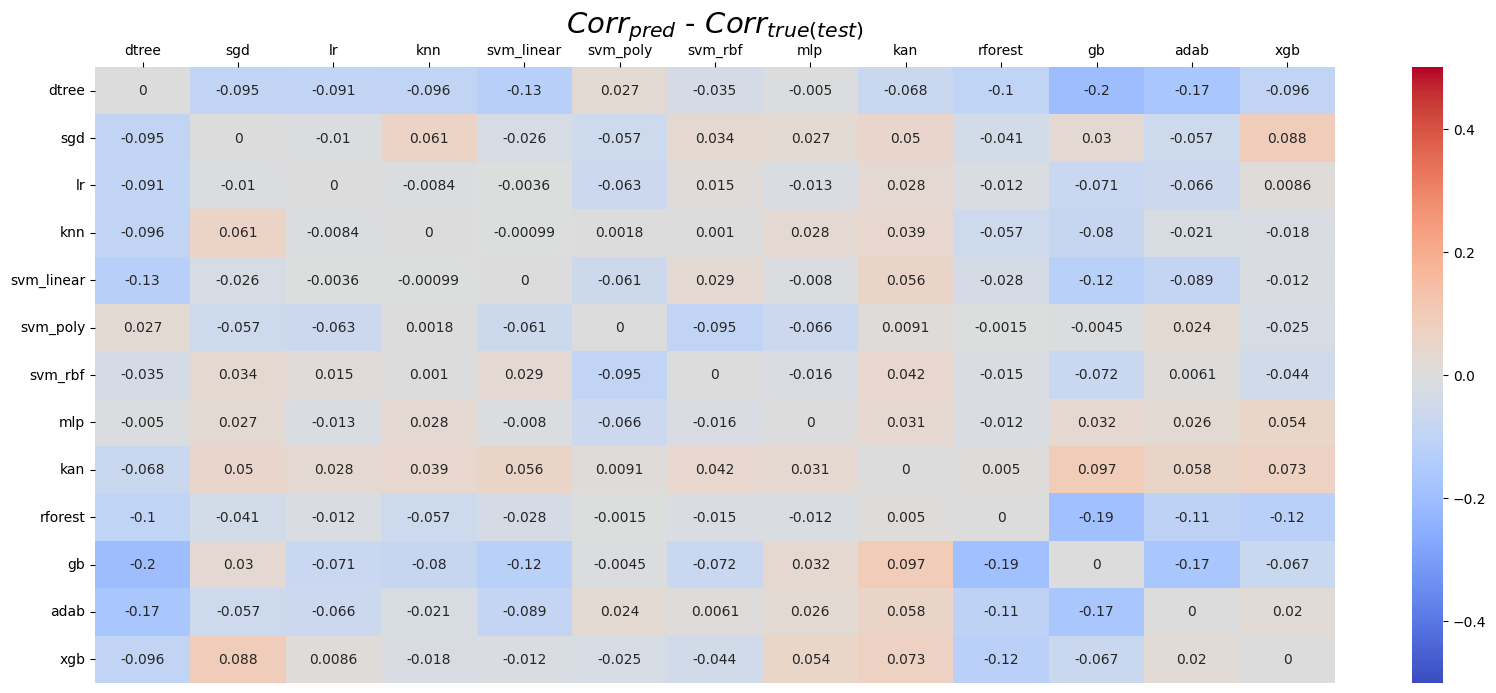

In [359]:
morGroups_corrls = y_pred.corr('pearson')
#pred_corrls2 = ya_test.corr('pearson')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
RMSE: {rmse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}''')

mse_df.loc['multi-output(group)',:] = mse_models(ya_test, y_pred)
rmse_df.loc['multi-output(group)',:] = rmse_models(ya_test, y_pred)
mae_df.loc['multi-output(group)',:] = mae_models(ya_test, y_pred)
nmse_df.loc['multi-output(group)',:] = nmse_models(ya_test, y_pred)

plt.figure(figsize=(20,8))
plt.title('pearson Correlation', fontsize=21)
hm = sns.heatmap(morGroups_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

diff_corrls = morGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões dos assessores e do conjunto de teste:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls2)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

## Análises

In [293]:
def metricsFormat(df: pd.DataFrame, metric_name:str):
    df = df.reset_index().melt(id_vars='index', var_name='model', value_name=metric_name)
    df = df.rename(columns={'index': 'assessor_type'})

    return df

In [294]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(rmse_df, 'RMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE      RMSE       MAE      NMSE
0              regchain  dtree  0.091869  0.303099  0.227641  0.914335
1          multi-output  dtree  0.091869  0.303099  0.227641  0.914335
2            individual  dtree  0.093350  0.305533  0.231295  0.929076
3       regchain(group)  dtree  0.091869  0.303099  0.227641  0.914335
4   multi-output(group)  dtree  0.091869  0.303099  0.227641  0.914335
..                  ...    ...       ...       ...       ...       ...
60             regchain    xgb  0.105586  0.324940  0.243852  1.131610
61         multi-output    xgb  0.101638  0.318808  0.244208  1.089298
62           individual    xgb  0.086256  0.293694  0.229022  0.924442
63      regchain(group)    xgb  0.101638  0.318808  0.244208  1.089298
64  multi-output(group)    xgb  0.101638  0.318808  0.244208  1.089298

[65 rows x 6 columns]

In [295]:
teste = metrics_df.drop(columns=['model']).groupby(['assessor_type']).agg(['mean', 'std'])
#teste.to_csv('data/heart/results.csv')
teste

MSE                RMSE                 MAE  \
                         mean       std      mean       std      mean   
assessor_type                                                           
individual           0.067220  0.035994  0.251019  0.067528  0.196317   
multi-output         0.069453  0.038255  0.254646  0.070653  0.197251   
multi-output(group)  0.069453  0.038255  0.254646  0.070653  0.197251   
regchain             0.066201  0.033963  0.249287  0.066293  0.192944   
regchain(group)      0.067840  0.037864  0.251649  0.069925  0.195822   

                                   NMSE            
                          std      mean       std  
assessor_type                                      
individual           0.054071  1.020568  0.102351  
multi-output         0.054631  1.044975  0.101072  
multi-output(group)  0.054631  1.044975  0.101072  
regchain             0.052462  1.005892  0.094871  
regchain(group)      0.054588  1.020039  0.079773

In [296]:
class_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2], sns.color_palette()[-1], sns.color_palette()[1]]

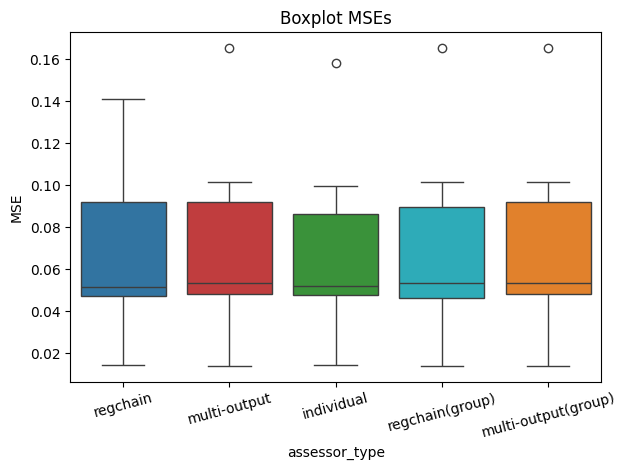

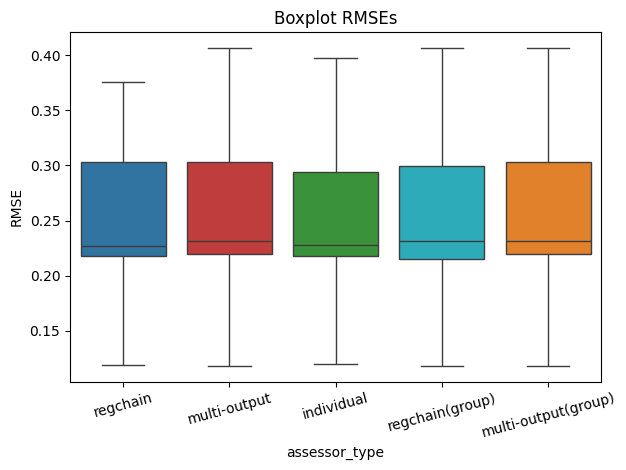

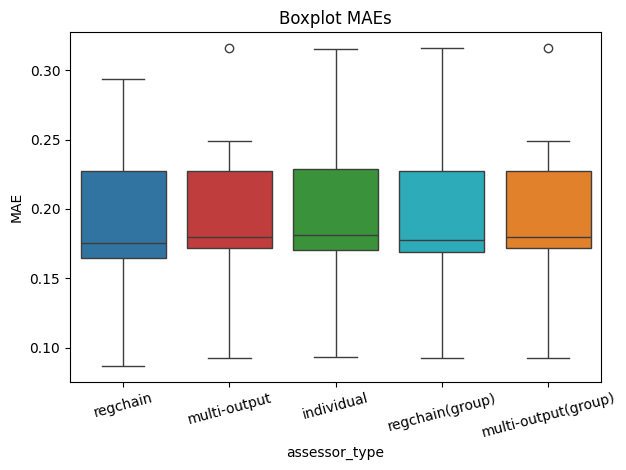

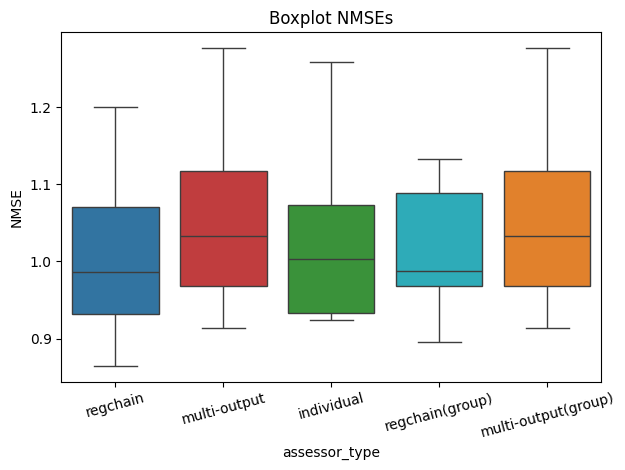

In [297]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.title(f'Boxplot {mt}s')
    sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

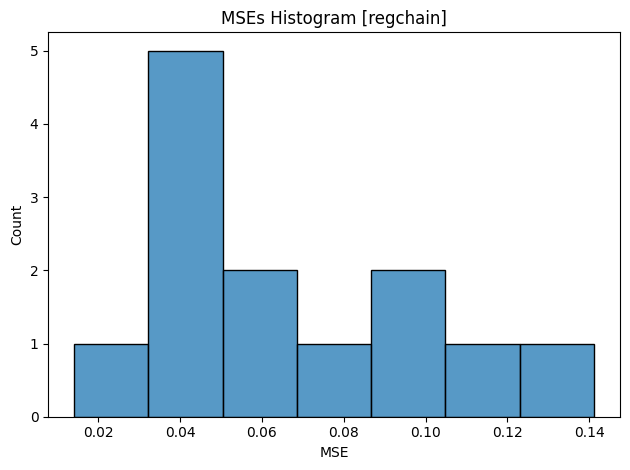

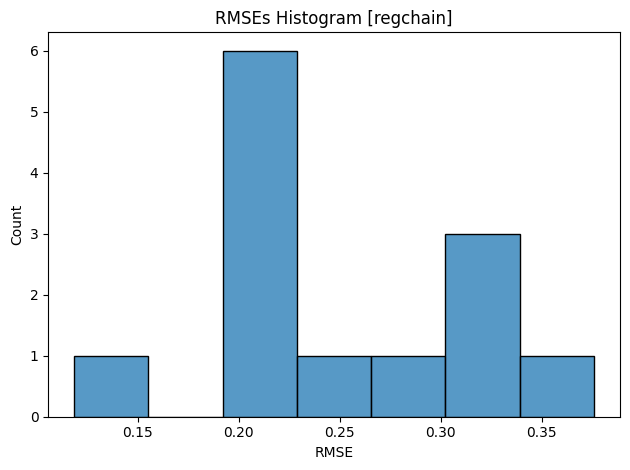

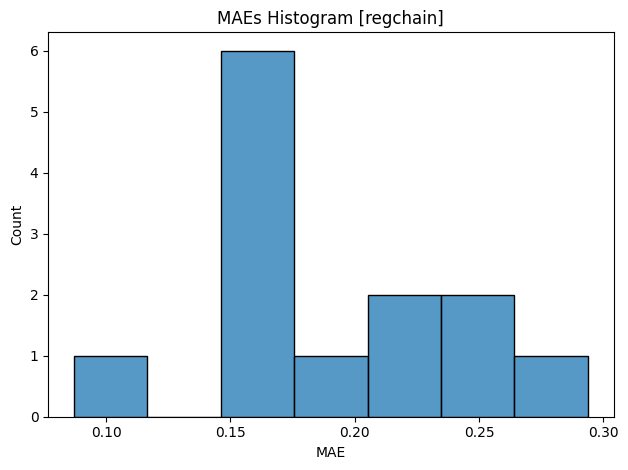

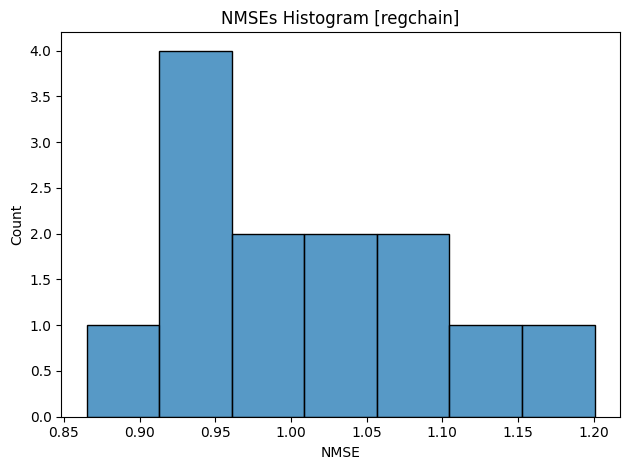

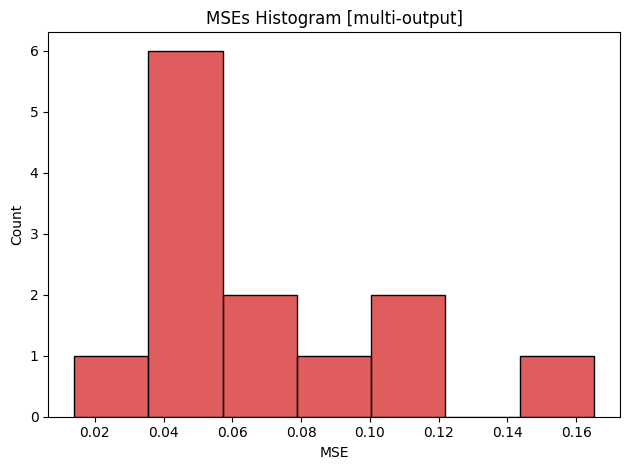

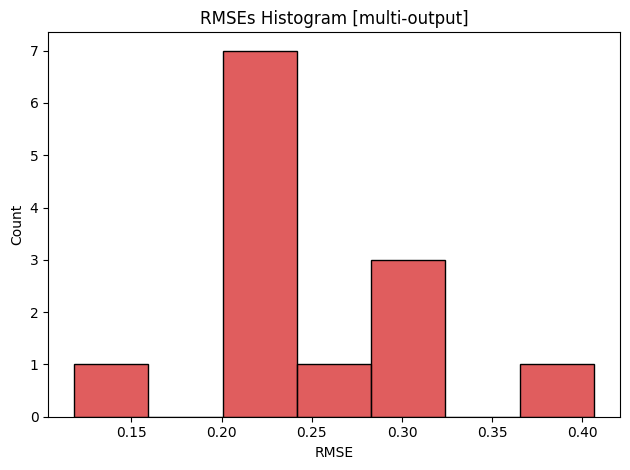

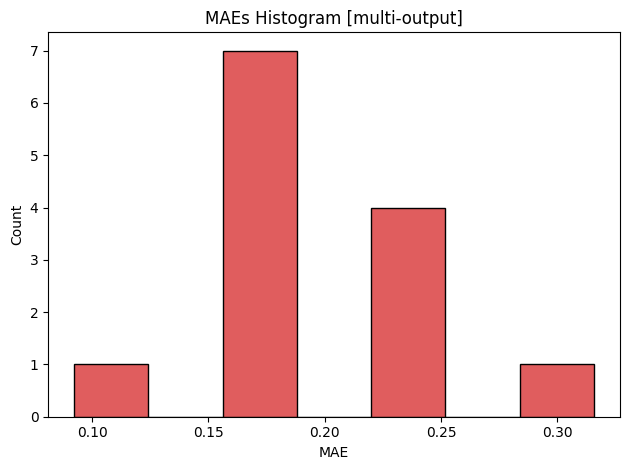

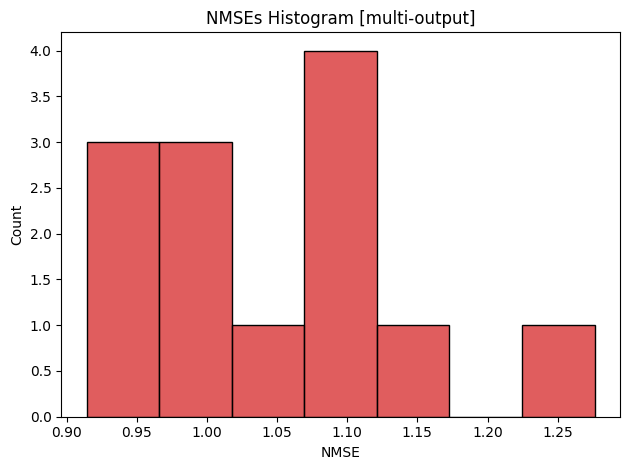

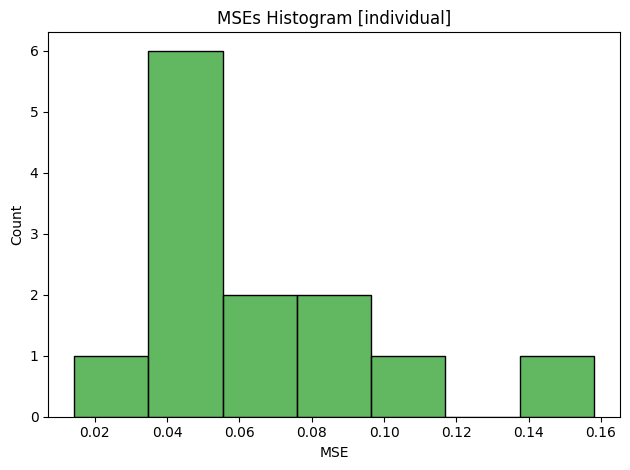

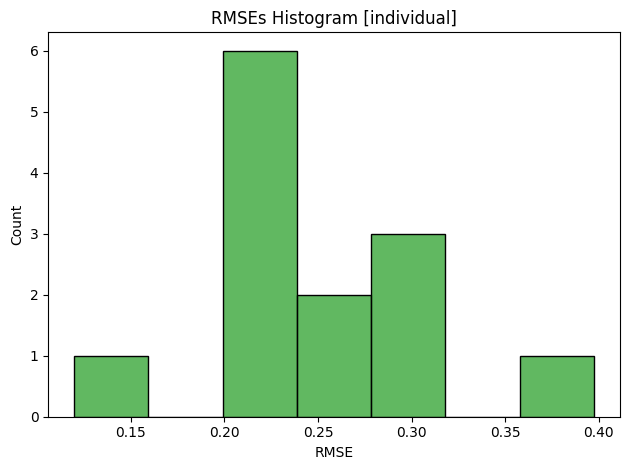

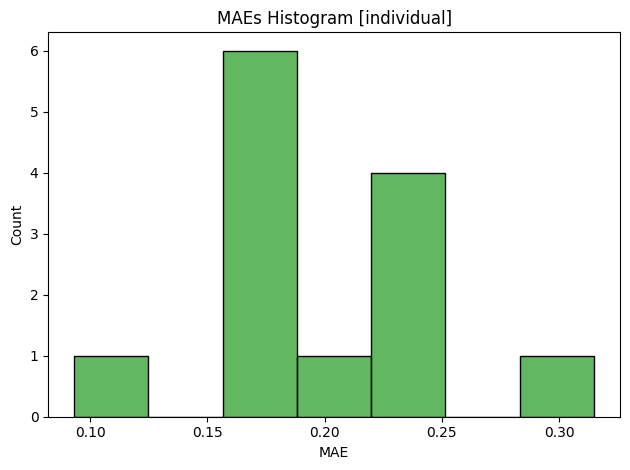

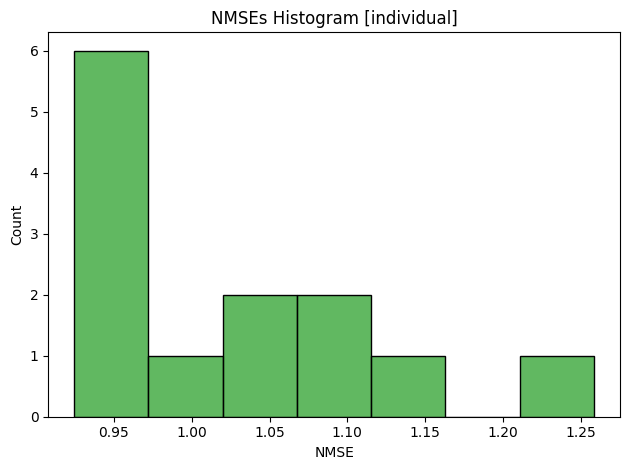

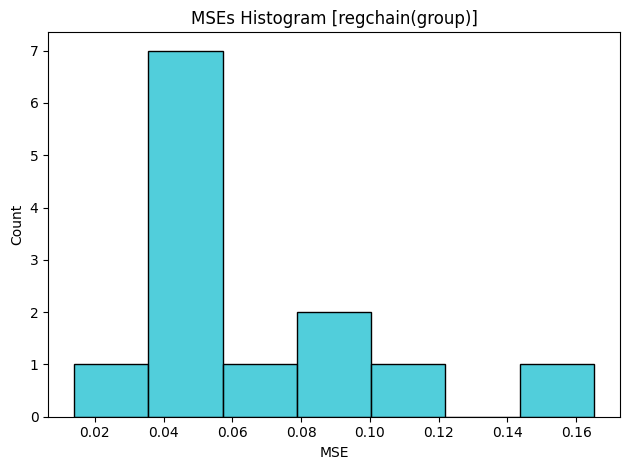

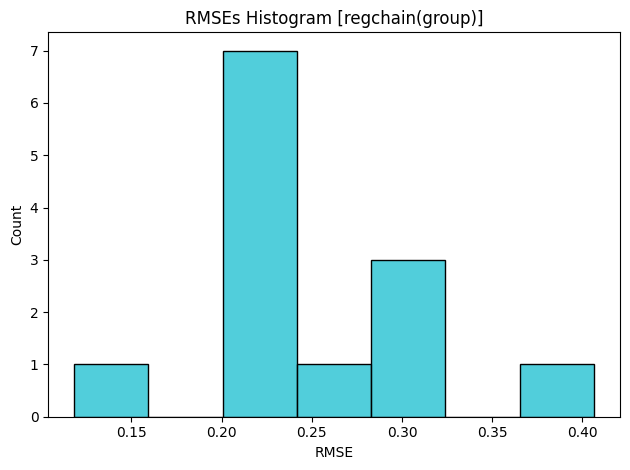

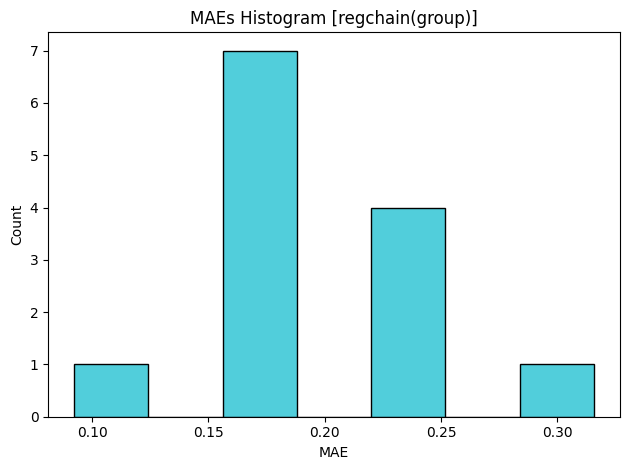

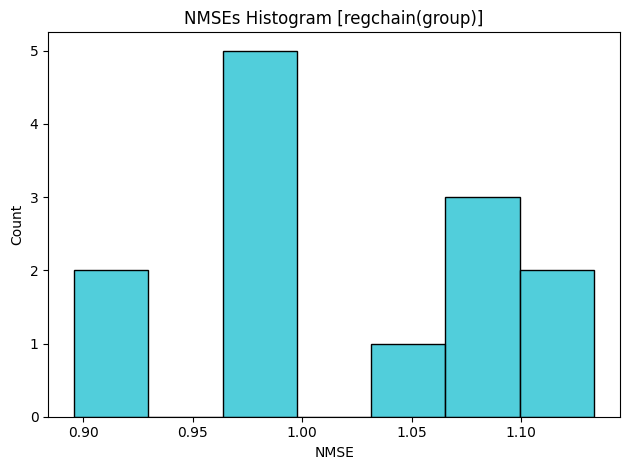

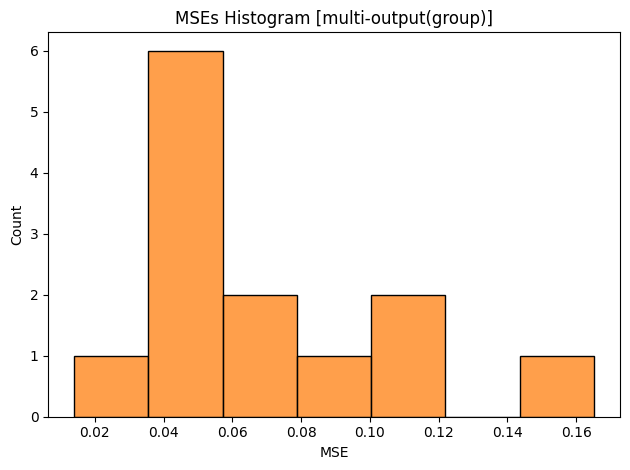

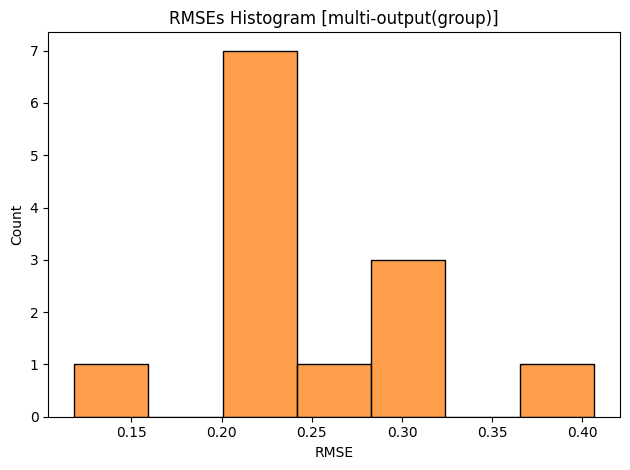

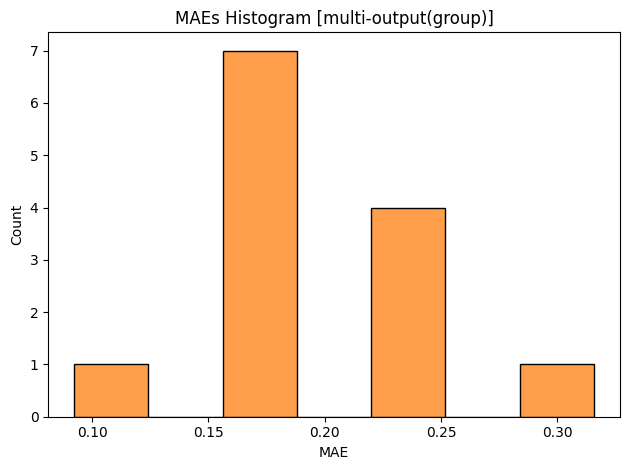

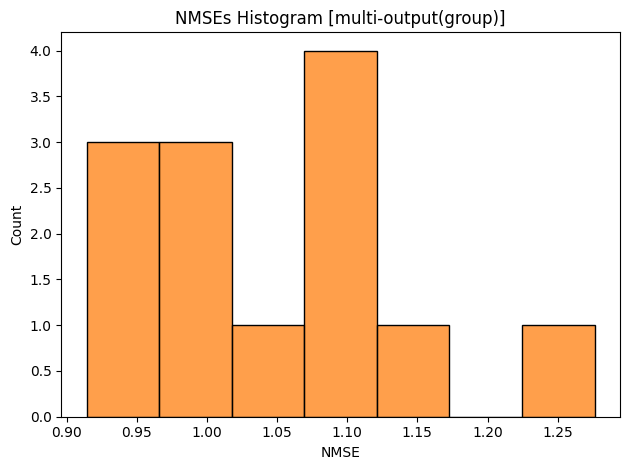

In [298]:
teste = {'regchain': class_palette[0], 
         'multi-output': class_palette[1], 
         'individual': class_palette[2],
         'regchain(group)': class_palette[3],
         'multi-output(group)': class_palette[4]}

for a in teste.keys():
    for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
        plt.title(f'{mt}s Histogram [{a}]')
        sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=teste[a])
        plt.tight_layout()
        plt.show()

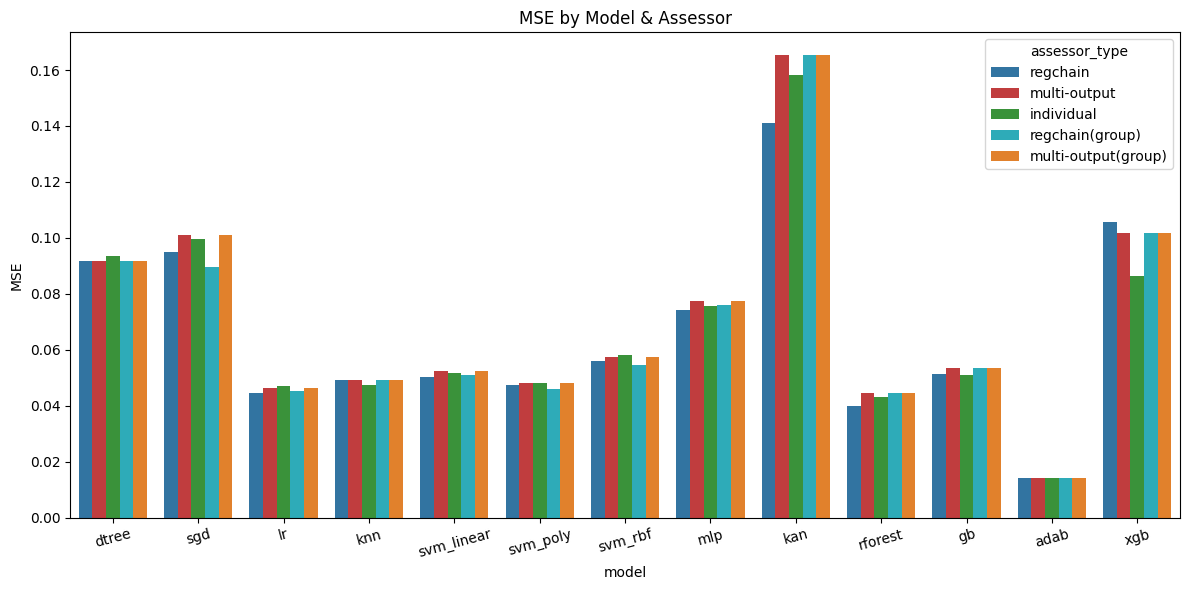

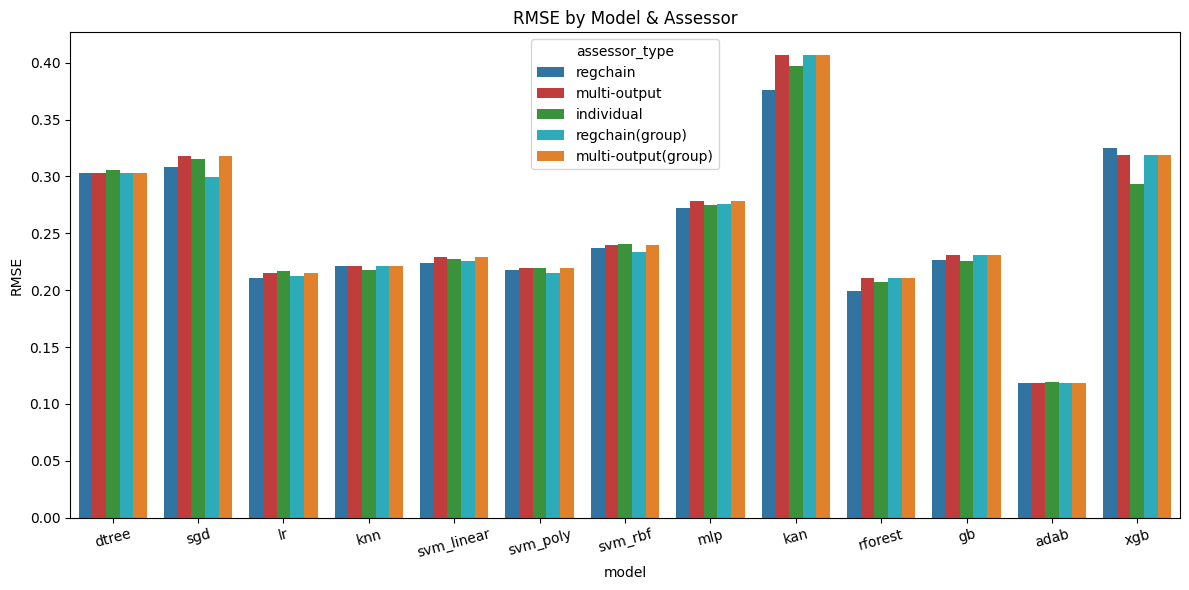

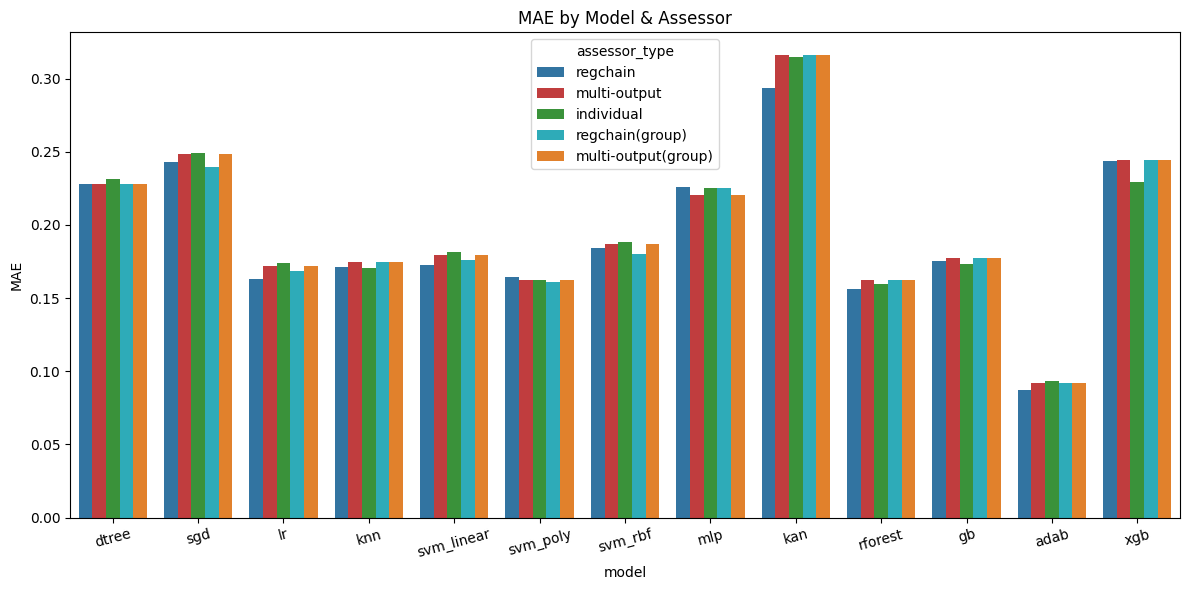

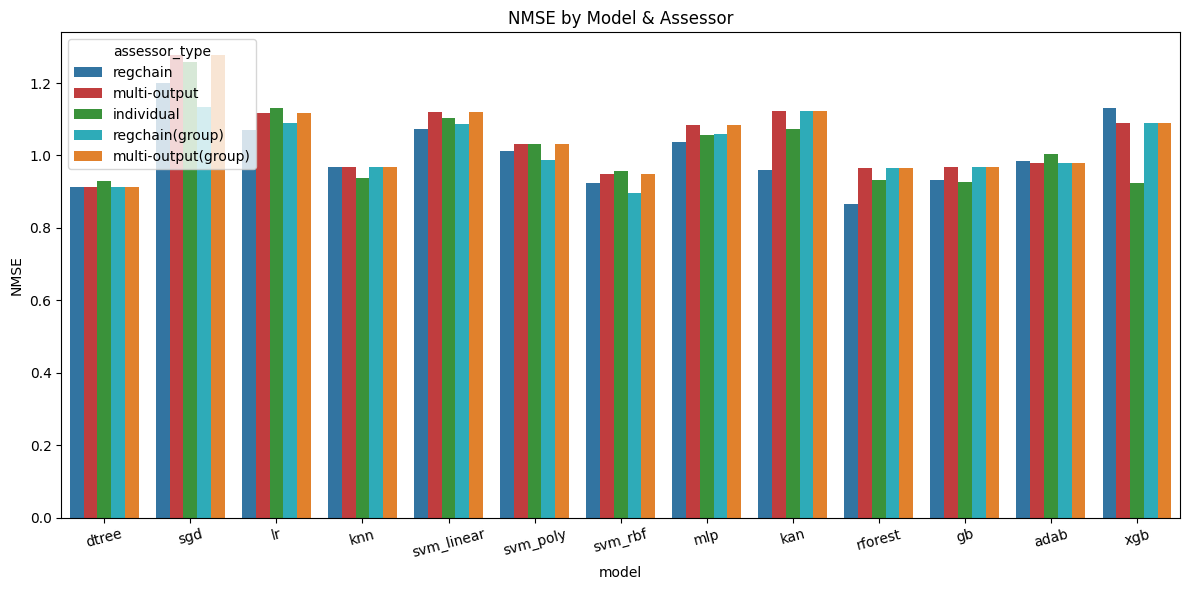

In [299]:
for mt in ['MSE', 'RMSE', 'MAE', 'NMSE']:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()